<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html week44.do.txt --no_mako -->
<!-- dom:TITLE: Week 44,  Solving differential equations with neural networks and start Convolutional Neural Networks (CNN) -->

# Week 44,  Solving differential equations with neural networks and start Convolutional Neural Networks (CNN)
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo, Norway

Date: **Week 44**

## Plan for week 44

**Material for the lecture Monday October 27, 2025.**

1. Solving differential equations, continuation from last week, first lecture

2. Convolutional  Neural Networks, second lecture

3. Readings and Videos:

  * These lecture notes at <https://github.com/CompPhysics/MachineLearning/blob/master/doc/pub/week44/ipynb/week44.ipynb>

  * For a more in depth discussion on  neural networks we recommend Goodfellow et al chapter 9. See also chapter 11 and 12 on practicalities and applications

  * Reading suggestions for implementation of CNNs see Rashcka et al.'s chapter 14 at <https://github.com/rasbt/machine-learning-book/tree/main/ch14>.     

  * Video on Deep Learning at <https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi>

  * Video  on Convolutional Neural Networks from MIT at <https://www.youtube.com/watch?v=iaSUYvmCekI&ab_channel=AlexanderAmini>

  * Video on CNNs from Stanford at <https://www.youtube.com/watch?v=bNb2fEVKeEo&list=PLC1qU-LWwrF64f4QKQT-Vg5Wr4qEE1Zxk&index=6&ab_channel=StanfordUniversitySchoolofEngineering>
<!-- * Video of lecture October 28 at <https://youtu.be/rfrSfikAz94> -->
<!-- * Whiteboard notes at <https://github.com/CompPhysics/MachineLearning/blob/master/doc/HandWrittenNotes/2024/NotesOctober28> -->

## Lab  sessions on Tuesday and Wednesday

* Main focus is discussion of and work on project 2

* If you did not get time to finish the exercises from weeks 41-42, you can also keep working on them and hand in this coming Friday

## Material for Lecture Monday October 27

## Solving differential equations  with Deep Learning

The Universal Approximation Theorem states that a neural network can
approximate any function at a single hidden layer along with one input
and output layer to any given precision.

**Book on solving differential equations with ML methods.**

[An Introduction to Neural Network Methods for Differential Equations](https://www.springer.com/gp/book/9789401798150), by Yadav and Kumar.

**Physics informed neural networks.**

[Scientific Machine Learning Through Physics–Informed Neural Networks: Where we are and What’s Next](https://link.springer.com/article/10.1007/s10915-022-01939-z), by Cuomo et al

**Thanks to Kristine Baluka Hein.**

The lectures on differential equations were developed by Kristine Baluka Hein, now PhD student at IFI.
A great thanks to Kristine.

## Ordinary Differential Equations first

An ordinary differential equation (ODE) is an equation involving functions having one variable.

In general, an ordinary differential equation looks like

<!-- Equation labels as ordinary links -->
<div id="ode"></div>

$$
\begin{equation} \label{ode} \tag{1}
f\left(x, \, g(x), \, g'(x), \, g''(x), \, \dots \, , \, g^{(n)}(x)\right) = 0
\end{equation}
$$

where $g(x)$ is the function to find, and $g^{(n)}(x)$ is the $n$-th derivative of $g(x)$.

The $f\left(x, g(x), g'(x), g''(x), \, \dots \, , g^{(n)}(x)\right)$ is just a way to write that there is an expression involving $x$ and $g(x), \ g'(x), \ g''(x), \, \dots \, , \text{ and } g^{(n)}(x)$ on the left side of the equality sign in ([1](#ode)).
The highest order of derivative, that is the value of $n$, determines to the order of the equation.
The equation is referred to as a $n$-th order ODE.
Along with ([1](#ode)), some additional conditions of the function $g(x)$ are typically given
for the solution to be unique.

## The trial solution

Let the trial solution $g_t(x)$ be

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
	g_t(x) = h_1(x) + h_2(x,N(x,P))
\label{_auto1} \tag{2}
\end{equation}
$$

where $h_1(x)$ is a function that makes $g_t(x)$ satisfy a given set
of conditions, $N(x,P)$ a neural network with weights and biases
described by $P$ and $h_2(x, N(x,P))$ some expression involving the
neural network.  The role of the function $h_2(x, N(x,P))$, is to
ensure that the output from $N(x,P)$ is zero when $g_t(x)$ is
evaluated at the values of $x$ where the given conditions must be
satisfied.  The function $h_1(x)$ should alone make $g_t(x)$ satisfy
the conditions.

But what about the network $N(x,P)$?

As described previously, an optimization method could be used to minimize the parameters of a neural network, that being its weights and biases, through backward propagation.

## Minimization process

For the minimization to be defined, we need to have a cost function at hand to minimize.

It is given that $f\left(x, \, g(x), \, g'(x), \, g''(x), \, \dots \, , \, g^{(n)}(x)\right)$ should be equal to zero in ([1](#ode)).
We can choose to consider the mean squared error as the cost function for an input $x$.
Since we are looking at one input, the cost function is just $f$ squared.
The cost function $c\left(x, P \right)$ can therefore be expressed as

$$
C\left(x, P\right) = \big(f\left(x, \, g(x), \, g'(x), \, g''(x), \, \dots \, , \, g^{(n)}(x)\right)\big)^2
$$

If $N$ inputs are given as a vector $\boldsymbol{x}$ with elements $x_i$ for $i = 1,\dots,N$,
the cost function becomes

<!-- Equation labels as ordinary links -->
<div id="cost"></div>

$$
\begin{equation} \label{cost} \tag{3}
	C\left(\boldsymbol{x}, P\right) = \frac{1}{N} \sum_{i=1}^N \big(f\left(x_i, \, g(x_i), \, g'(x_i), \, g''(x_i), \, \dots \, , \, g^{(n)}(x_i)\right)\big)^2
\end{equation}
$$

The neural net should then find the parameters $P$ that minimizes the cost function in
([3](#cost)) for a set of $N$ training samples $x_i$.

## Minimizing the cost function using gradient descent and automatic differentiation

To perform the minimization using gradient descent, the gradient of $C\left(\boldsymbol{x}, P\right)$ is needed.
It might happen so that finding an analytical expression of the gradient of $C(\boldsymbol{x}, P)$ from ([3](#cost)) gets too messy, depending on which cost function one desires to use.

Luckily, there exists libraries that makes the job for us through automatic differentiation.
Automatic differentiation is a method of finding the derivatives numerically with very high precision.

## Example: Exponential decay

An exponential decay of a quantity $g(x)$ is described by the equation

<!-- Equation labels as ordinary links -->
<div id="solve_expdec"></div>

$$
\begin{equation} \label{solve_expdec} \tag{4}
  g'(x) = -\gamma g(x)
\end{equation}
$$

with $g(0) = g_0$ for some chosen initial value $g_0$.

The analytical solution of ([4](#solve_expdec)) is

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation}
  g(x) = g_0 \exp\left(-\gamma x\right)
\label{_auto2} \tag{5}
\end{equation}
$$

Having an analytical solution at hand, it is possible to use it to compare how well a neural network finds a solution of ([4](#solve_expdec)).

## The function to solve for

The program will use a neural network to solve

<!-- Equation labels as ordinary links -->
<div id="solveode"></div>

$$
\begin{equation} \label{solveode} \tag{6}
g'(x) = -\gamma g(x)
\end{equation}
$$

where $g(0) = g_0$ with $\gamma$ and $g_0$ being some chosen values.

In this example, $\gamma = 2$ and $g_0 = 10$.

## The trial solution
To begin with, a trial solution $g_t(t)$ must be chosen. A general trial solution for ordinary differential equations could be

$$
g_t(x, P) = h_1(x) + h_2(x, N(x, P))
$$

with $h_1(x)$ ensuring that $g_t(x)$ satisfies some conditions and $h_2(x,N(x, P))$ an expression involving $x$ and the output from the neural network $N(x,P)$ with $P $ being the collection of the weights and biases for each layer. For now, it is assumed that the network consists of one input layer, one hidden layer, and one output layer.

## Setup of Network

In this network, there are no weights and bias at the input layer, so $P = \{ P_{\text{hidden}},  P_{\text{output}} \}$.
If there are $N_{\text{hidden} }$ neurons in the hidden layer, then $P_{\text{hidden}}$ is a $N_{\text{hidden} } \times (1 + N_{\text{input}})$ matrix, given that there are $N_{\text{input}}$ neurons in the input layer.

The first column in $P_{\text{hidden} }$ represents the bias for each neuron in the hidden layer and the second column represents the weights for each neuron in the hidden layer from the input layer.
If there are $N_{\text{output} }$ neurons in the output layer, then $P_{\text{output}} $ is a $N_{\text{output} } \times (1 + N_{\text{hidden} })$ matrix.

Its first column represents the bias of each neuron and the remaining columns represents the weights to each neuron.

It is given that $g(0) = g_0$. The trial solution must fulfill this condition to be a proper solution of ([6](#solveode)). A possible way to ensure that $g_t(0, P) = g_0$, is to let $F(N(x,P)) = x \cdot N(x,P)$ and $h_1(x) = g_0$. This gives the following trial solution:

<!-- Equation labels as ordinary links -->
<div id="trial"></div>

$$
\begin{equation} \label{trial} \tag{7}
g_t(x, P) = g_0 + x \cdot N(x, P)
\end{equation}
$$

## Reformulating the problem

We wish that our neural network manages to minimize a given cost function.

A reformulation of out equation, ([6](#solveode)), must therefore be done,
such that it describes the problem a neural network can solve for.

The neural network must find the set of weights and biases $P$ such that the trial solution in ([7](#trial)) satisfies ([6](#solveode)).

The trial solution

$$
g_t(x, P) = g_0 + x \cdot N(x, P)
$$

has been chosen such that it already solves the condition $g(0) = g_0$. What remains, is to find $P$ such that

<!-- Equation labels as ordinary links -->
<div id="nnmin"></div>

$$
\begin{equation} \label{nnmin} \tag{8}
g_t'(x, P) = - \gamma g_t(x, P)
\end{equation}
$$

is fulfilled as *best as possible*.

## More technicalities

The left hand side and right hand side of ([8](#nnmin)) must be computed separately, and then the neural network must choose weights and biases, contained in $P$, such that the sides are equal as best as possible.
This means that the absolute or squared difference between the sides must be as close to zero, ideally equal to zero.
In this case, the difference squared shows to be an appropriate measurement of how erroneous the trial solution is with respect to $P$ of the neural network.

This gives the following cost function our neural network must solve for:

$$
\min_{P}\Big\{ \big(g_t'(x, P) - ( -\gamma g_t(x, P) \big)^2 \Big\}
$$

(the notation $\min_{P}\{ f(x, P) \}$ means that we desire to find $P$ that yields the minimum of $f(x, P)$)

or, in terms of weights and biases for the hidden and output layer in our network:

$$
\min_{P_{\text{hidden} }, \ P_{\text{output} }}\Big\{ \big(g_t'(x, \{ P_{\text{hidden} }, P_{\text{output} }\}) - ( -\gamma g_t(x, \{ P_{\text{hidden} }, P_{\text{output} }\}) \big)^2 \Big\}
$$

for an input value $x$.

## More details

If the neural network evaluates $g_t(x, P)$ at more values for $x$, say $N$ values $x_i$ for $i = 1, \dots, N$, then the *total* error to minimize becomes

<!-- Equation labels as ordinary links -->
<div id="min"></div>

$$
\begin{equation} \label{min} \tag{9}
\min_{P}\Big\{\frac{1}{N} \sum_{i=1}^N  \big(g_t'(x_i, P) - ( -\gamma g_t(x_i, P) \big)^2 \Big\}
\end{equation}
$$

Letting $\boldsymbol{x}$ be a vector with elements $x_i$ and $C(\boldsymbol{x}, P) = \frac{1}{N} \sum_i  \big(g_t'(x_i, P) - ( -\gamma g_t(x_i, P) \big)^2$ denote the cost function, the minimization problem that our network must solve, becomes

$$
\min_{P} C(\boldsymbol{x}, P)
$$

In terms of $P_{\text{hidden} }$ and $P_{\text{output} }$, this could also be expressed as

$$
\min_{P_{\text{hidden} }, \ P_{\text{output} }} C(\boldsymbol{x}, \{P_{\text{hidden} }, P_{\text{output} }\})
$$

## A possible implementation of a neural network

For simplicity, it is assumed that the input is an array $\boldsymbol{x} = (x_1, \dots, x_N)$ with $N$ elements. It is at these points the neural network should find $P$ such that it fulfills ([9](#min)).

First, the neural network must feed forward the inputs.
This means that $\boldsymbol{x}s$ must be passed through an input layer, a hidden layer and a output layer. The input layer in this case, does not need to process the data any further.
The input layer will consist of $N_{\text{input} }$ neurons, passing its element to each neuron in the hidden layer.  The number of neurons in the hidden layer will be $N_{\text{hidden} }$.

## Technicalities

For the $i$-th in the hidden layer with weight $w_i^{\text{hidden} }$ and bias $b_i^{\text{hidden} }$, the weighting from the $j$-th neuron at the input layer is:

$$
\begin{aligned}
z_{i,j}^{\text{hidden}} &= b_i^{\text{hidden}} + w_i^{\text{hidden}}x_j \\
&=
\begin{pmatrix}
b_i^{\text{hidden}} & w_i^{\text{hidden}}
\end{pmatrix}
\begin{pmatrix}
1 \\
x_j
\end{pmatrix}
\end{aligned}
$$

## Final technicalities I

The result after weighting the inputs at the $i$-th hidden neuron can be written as a vector:

$$
\begin{aligned}
\boldsymbol{z}_{i}^{\text{hidden}} &= \Big( b_i^{\text{hidden}} + w_i^{\text{hidden}}x_1 , \ b_i^{\text{hidden}} + w_i^{\text{hidden}} x_2, \ \dots \, , \ b_i^{\text{hidden}} + w_i^{\text{hidden}} x_N\Big)  \\
&=
\begin{pmatrix}
 b_i^{\text{hidden}}  & w_i^{\text{hidden}}
\end{pmatrix}
\begin{pmatrix}
1  & 1 & \dots & 1 \\
x_1 & x_2 & \dots & x_N
\end{pmatrix} \\
&= \boldsymbol{p}_{i, \text{hidden}}^T X
\end{aligned}
$$

## Final technicalities II

The vector $\boldsymbol{p}_{i, \text{hidden}}^T$ constitutes each row in $P_{\text{hidden} }$, which contains the weights for the neural network to minimize according to ([9](#min)).

After having found $\boldsymbol{z}_{i}^{\text{hidden}} $ for every $i$-th neuron within the hidden layer, the vector will be sent to an activation function $a_i(\boldsymbol{z})$.

In this example, the sigmoid function has been chosen to be the activation function for each hidden neuron:

$$
f(z) = \frac{1}{1 + \exp{(-z)}}
$$

It is possible to use other activations functions for the hidden layer also.

The output $\boldsymbol{x}_i^{\text{hidden}}$ from each $i$-th hidden neuron is:

$$
\boldsymbol{x}_i^{\text{hidden} } = f\big(  \boldsymbol{z}_{i}^{\text{hidden}} \big)
$$

The outputs $\boldsymbol{x}_i^{\text{hidden} } $ are then sent to the output layer.

The output layer consists of one neuron in this case, and combines the
output from each of the neurons in the hidden layers. The output layer
combines the results from the hidden layer using some weights $w_i^{\text{output}}$
and biases $b_i^{\text{output}}$. In this case,
it is assumes that the number of neurons in the output layer is one.

## Final technicalities III

The procedure of weighting the output neuron $j$ in the hidden layer to the $i$-th neuron in the output layer is similar as for the hidden layer described previously.

$$
\begin{aligned}
z_{1,j}^{\text{output}} & =
\begin{pmatrix}
b_1^{\text{output}} & \boldsymbol{w}_1^{\text{output}}
\end{pmatrix}
\begin{pmatrix}
1 \\
\boldsymbol{x}_j^{\text{hidden}}
\end{pmatrix}
\end{aligned}
$$

## Final technicalities IV

Expressing $z_{1,j}^{\text{output}}$ as a vector gives the following way of weighting the inputs from the hidden layer:

$$
\boldsymbol{z}_{1}^{\text{output}} =
\begin{pmatrix}
b_1^{\text{output}} & \boldsymbol{w}_1^{\text{output}}
\end{pmatrix}
\begin{pmatrix}
1  & 1 & \dots & 1 \\
\boldsymbol{x}_1^{\text{hidden}} & \boldsymbol{x}_2^{\text{hidden}} & \dots & \boldsymbol{x}_N^{\text{hidden}}
\end{pmatrix}
$$

In this case we seek a continuous range of values since we are approximating a function. This means that after computing $\boldsymbol{z}_{1}^{\text{output}}$ the neural network has finished its feed forward step, and $\boldsymbol{z}_{1}^{\text{output}}$ is the final output of the network.

## Back propagation

The next step is to decide how the parameters should be changed such that they minimize the cost function.

The chosen cost function for this problem is

$$
C(\boldsymbol{x}, P) = \frac{1}{N} \sum_i  \big(g_t'(x_i, P) - ( -\gamma g_t(x_i, P) \big)^2
$$

In order to minimize the cost function, an optimization method must be chosen.

Here, gradient descent with a constant step size has been chosen.

## Gradient descent

The idea of the gradient descent algorithm is to update parameters in
a direction where the cost function decreases goes to a minimum.

In general, the update of some parameters $\boldsymbol{\omega}$ given a cost
function defined by some weights $\boldsymbol{\omega}$, $C(\boldsymbol{x},
\boldsymbol{\omega})$, goes as follows:

$$
\boldsymbol{\omega}_{\text{new} } = \boldsymbol{\omega} - \lambda \nabla_{\boldsymbol{\omega}} C(\boldsymbol{x}, \boldsymbol{\omega})
$$

for a number of iterations or until $ \big|\big| \boldsymbol{\omega}_{\text{new} } - \boldsymbol{\omega} \big|\big|$ becomes smaller than some given tolerance.

The value of $\lambda$ decides how large steps the algorithm must take
in the direction of $ \nabla_{\boldsymbol{\omega}} C(\boldsymbol{x}, \boldsymbol{\omega})$.
The notation $\nabla_{\boldsymbol{\omega}}$ express the gradient with respect
to the elements in $\boldsymbol{\omega}$.

In our case, we have to minimize the cost function $C(\boldsymbol{x}, P)$ with
respect to the two sets of weights and biases, that is for the hidden
layer $P_{\text{hidden} }$ and for the output layer $P_{\text{output}
}$ .

This means that $P_{\text{hidden} }$ and $P_{\text{output} }$ is updated by

$$
\begin{aligned}
P_{\text{hidden},\text{new}} &= P_{\text{hidden}} - \lambda \nabla_{P_{\text{hidden}}} C(\boldsymbol{x}, P)  \\
P_{\text{output},\text{new}} &= P_{\text{output}} - \lambda \nabla_{P_{\text{output}}} C(\boldsymbol{x}, P)
\end{aligned}
$$

## The code for solving the ODE

Initial cost: 367.01
Final cost: 0.0666807
Max absolute difference: 0.0437499


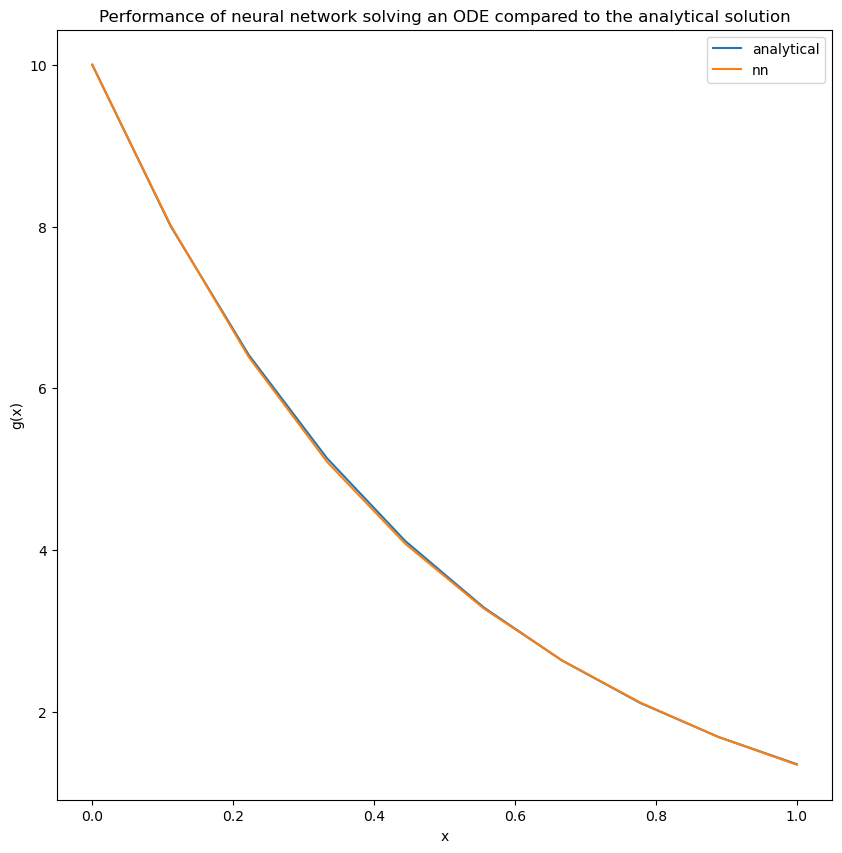

In [2]:
%matplotlib inline

import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

# Assuming one input, hidden, and output layer
def neural_network(params, x):

    # Find the weights (including and biases) for the hidden and output layer.
    # Assume that params is a list of parameters for each layer.
    # The biases are the first element for each array in params,
    # and the weights are the remaning elements in each array in params.

    w_hidden = params[0]
    w_output = params[1]

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    ## Hidden layer:

    # Add a row of ones to include bias
    x_input = np.concatenate((np.ones((1,num_values)), x_input ), axis = 0)

    z_hidden = np.matmul(w_hidden, x_input)
    x_hidden = sigmoid(z_hidden)

    ## Output layer:

    # Include bias:
    x_hidden = np.concatenate((np.ones((1,num_values)), x_hidden ), axis = 0)

    z_output = np.matmul(w_output, x_hidden)
    x_output = z_output

    return x_output

# The trial solution using the deep neural network:
def g_trial(x,params, g0 = 10):
    return g0 + x*neural_network(params,x)

# The right side of the ODE:
def g(x, g_trial, gamma = 2):
    return -gamma*g_trial

# The cost function:
def cost_function(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial(x,P)

    # Find the derivative w.r.t x of the neural network
    d_net_out = elementwise_grad(neural_network,1)(P,x)

    # Find the derivative w.r.t x of the trial function
    d_g_t = elementwise_grad(g_trial,0)(x,P)

    # The right side of the ODE
    func = g(x, g_t)

    err_sqr = (d_g_t - func)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum / np.size(err_sqr)

# Solve the exponential decay ODE using neural network with one input, hidden, and output layer
def solve_ode_neural_network(x, num_neurons_hidden, num_iter, lmb):
    ## Set up initial weights and biases

    # For the hidden layer
    p0 = npr.randn(num_neurons_hidden, 2 )

    # For the output layer
    p1 = npr.randn(1, num_neurons_hidden + 1 ) # +1 since bias is included

    P = [p0, p1]

    print('Initial cost: %g'%cost_function(P, x))

    ## Start finding the optimal weights using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_grad = grad(cost_function,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of two arrays;
        # one for the gradient w.r.t P_hidden and
        # one for the gradient w.r.t P_output
        cost_grad =  cost_function_grad(P, x)

        P[0] = P[0] - lmb * cost_grad[0]
        P[1] = P[1] - lmb * cost_grad[1]

    print('Final cost: %g'%cost_function(P, x))

    return P

def g_analytic(x, gamma = 2, g0 = 10):
    return g0*np.exp(-gamma*x)

# Solve the given problem
if __name__ == '__main__':
    # Set seed such that the weight are initialized
    # with same weights and biases for every run.
    npr.seed(15)

    ## Decide the vales of arguments to the function to solve
    N = 10
    x = np.linspace(0, 1, N)

    ## Set up the initial parameters
    num_hidden_neurons = 10
    num_iter = 10000
    lmb = 0.001

    # Use the network
    P = solve_ode_neural_network(x, num_hidden_neurons, num_iter, lmb)

    # Print the deviation from the trial solution and true solution
    res = g_trial(x,P)
    res_analytical = g_analytic(x)

    print('Max absolute difference: %g'%np.max(np.abs(res - res_analytical)))

    # Plot the results
    plt.figure(figsize=(10,10))

    plt.title('Performance of neural network solving an ODE compared to the analytical solution')
    plt.plot(x, res_analytical)
    plt.plot(x, res[0,:])
    plt.legend(['analytical','nn'])
    plt.xlabel('x')
    plt.ylabel('g(x)')
    plt.show()

## The network with one input layer, specified number of hidden layers, and one output layer

It is also possible to extend the construction of our network into a more general one, allowing the network to contain more than one hidden layers.

The number of neurons within each hidden layer are given as a list of integers in the program below.

Initial cost: 324.246
Final cost: 0.119936


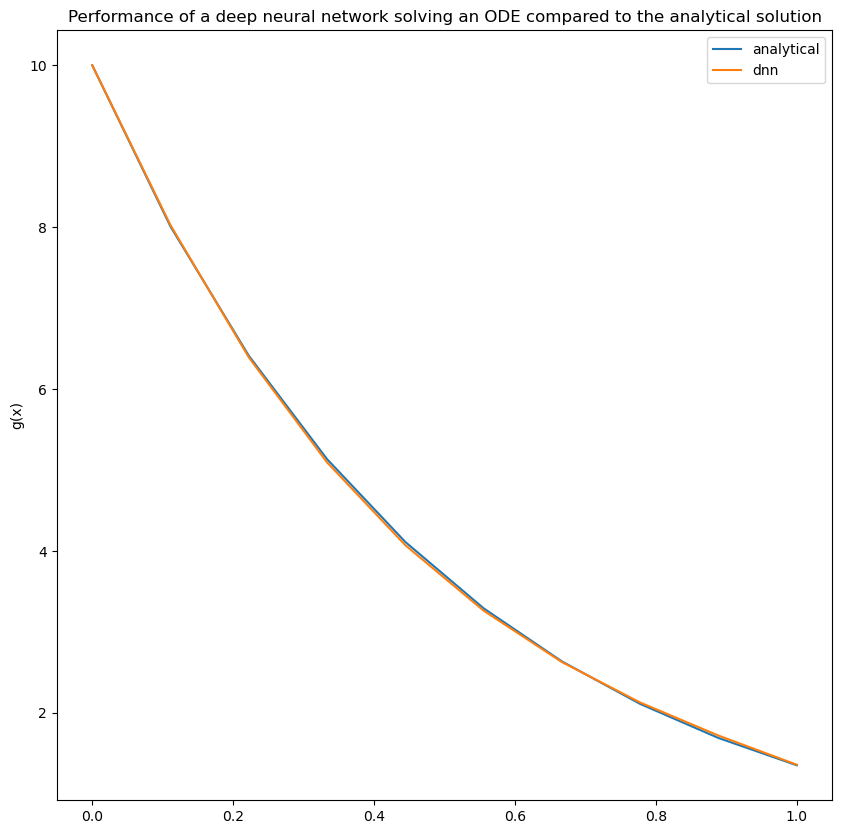

In [3]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

# The neural network with one input layer and one output layer,
# but with number of hidden layers specified by the user.
def deep_neural_network(deep_params, x):
    # N_hidden is the number of hidden layers
    # deep_params is a list, len() should be used
    N_hidden = len(deep_params) - 1 # -1 since params consists of
                                        # parameters to all the hidden
                                        # layers AND the output layer.

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output

# The trial solution using the deep neural network:
def g_trial_deep(x,params, g0 = 10):
    return g0 + x*deep_neural_network(params, x)

# The right side of the ODE:
def g(x, g_trial, gamma = 2):
    return -gamma*g_trial

# The same cost function as before, but calls deep_neural_network instead.
def cost_function_deep(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial_deep(x,P)

    # Find the derivative w.r.t x of the neural network
    d_net_out = elementwise_grad(deep_neural_network,1)(P,x)

    # Find the derivative w.r.t x of the trial function
    d_g_t = elementwise_grad(g_trial_deep,0)(x,P)

    # The right side of the ODE
    func = g(x, g_t)

    err_sqr = (d_g_t - func)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum / np.size(err_sqr)

# Solve the exponential decay ODE using neural network with one input and one output layer,
# but with specified number of hidden layers from the user.
def solve_ode_deep_neural_network(x, num_neurons, num_iter, lmb):
    # num_hidden_neurons is now a list of number of neurons within each hidden layer

    # The number of elements in the list num_hidden_neurons thus represents
    # the number of hidden layers.

    # Find the number of hidden layers:
    N_hidden = np.size(num_neurons)

    ## Set up initial weights and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 )
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: %g'%cost_function_deep(P, x))

    ## Start finding the optimal weights using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_deep_grad = grad(cost_function_deep,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of N_hidden + 1 arrays; the gradient w.r.t the weights and biases
        # in the hidden layers and output layers evaluated at x.
        cost_deep_grad =  cost_function_deep_grad(P, x)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_deep_grad[l]

    print('Final cost: %g'%cost_function_deep(P, x))

    return P

def g_analytic(x, gamma = 2, g0 = 10):
    return g0*np.exp(-gamma*x)

# Solve the given problem
if __name__ == '__main__':
    npr.seed(15)

    ## Decide the vales of arguments to the function to solve
    N = 10
    x = np.linspace(0, 1, N)

    ## Set up the initial parameters
    num_hidden_neurons = np.array([10,10])
    num_iter = 10000
    lmb = 0.001

    P = solve_ode_deep_neural_network(x, num_hidden_neurons, num_iter, lmb)

    res = g_trial_deep(x,P)
    res_analytical = g_analytic(x)

    plt.figure(figsize=(10,10))

    plt.title('Performance of a deep neural network solving an ODE compared to the analytical solution')
    plt.plot(x, res_analytical)
    plt.plot(x, res[0,:])
    plt.legend(['analytical','dnn'])
    plt.ylabel('g(x)')
    plt.show()

## Example: Population growth

A logistic model of population growth assumes that a population converges toward an equilibrium.
The population growth can be modeled by

<!-- Equation labels as ordinary links -->
<div id="log"></div>

$$
\begin{equation} \label{log} \tag{10}
	g'(t) = \alpha g(t)(A - g(t))
\end{equation}
$$

where $g(t)$ is the population density at time $t$, $\alpha > 0$ the growth rate and $A > 0$ is the maximum population number in the environment.
Also, at $t = 0$ the population has the size $g(0) = g_0$, where $g_0$ is some chosen constant.

In this example, similar network as for the exponential decay using Autograd has been used to solve the equation. However, as the implementation might suffer from e.g numerical instability
and high execution time (this might be more apparent in the examples solving PDEs),
using a library like  TensorFlow is recommended.
Here, we stay with a more simple approach and implement for comparison, the simple forward Euler method.

## Setting up the problem

Here, we will model a population $g(t)$ in an environment having carrying capacity $A$.
The population follows the model

<!-- Equation labels as ordinary links -->
<div id="solveode_population"></div>

$$
\begin{equation} \label{solveode_population} \tag{11}
g'(t) = \alpha g(t)(A - g(t))
\end{equation}
$$

where $g(0) = g_0$.

In this example, we let $\alpha = 2$, $A = 1$, and $g_0 = 1.2$.

## The trial solution

We will get a slightly different trial solution, as the boundary conditions are different
compared to the case for exponential decay.

A possible trial solution satisfying the condition $g(0) = g_0$ could be

$$
h_1(t) = g_0 + t \cdot N(t,P)
$$

with $N(t,P)$ being the output from the neural network with weights and biases for each layer collected in the set $P$.

The analytical solution is

$$
g(t) = \frac{Ag_0}{g_0 + (A - g_0)\exp(-\alpha A t)}
$$

## The program using Autograd

The network will be the similar as for the exponential decay example, but with some small modifications for our problem.

Initial cost: 0.221805
Final cost: 0.000417932
The max absolute difference between the solutions is: 0.00424909


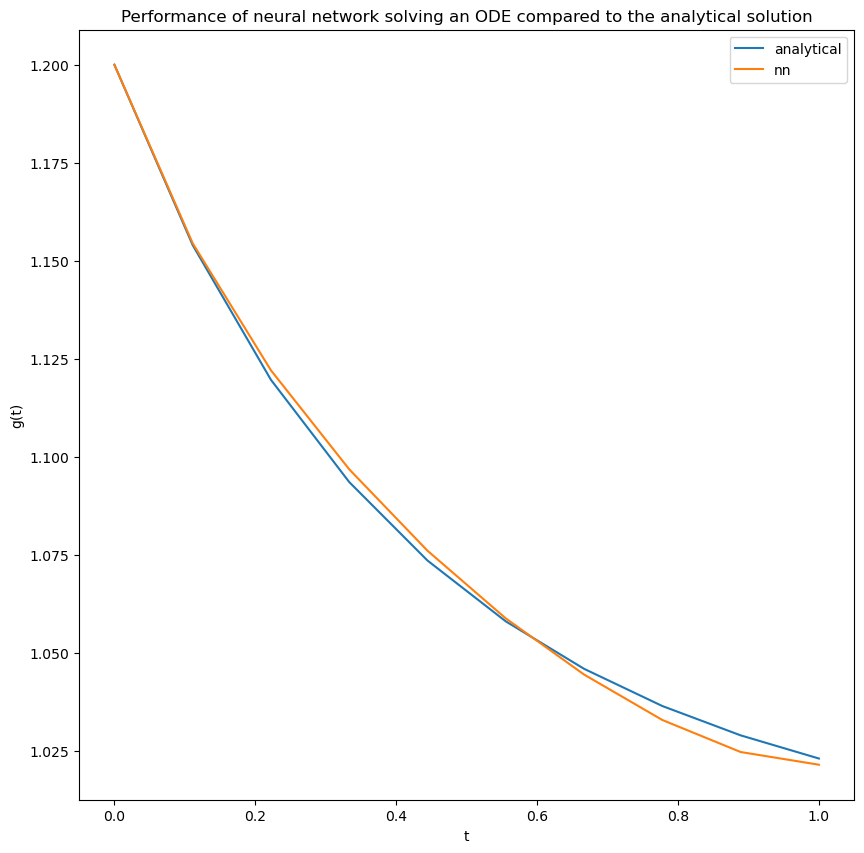

In [4]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

# Function to get the parameters.
# Done such that one can easily change the paramaters after one's liking.
def get_parameters():
    alpha = 2
    A = 1
    g0 = 1.2
    return alpha, A, g0

def deep_neural_network(deep_params, x):
    # N_hidden is the number of hidden layers
    # deep_params is a list, len() should be used
    N_hidden = len(deep_params) - 1 # -1 since params consists of
                                        # parameters to all the hidden
                                        # layers AND the output layer.

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output




def cost_function_deep(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial_deep(x,P)

    # Find the derivative w.r.t x of the trial function
    d_g_t = elementwise_grad(g_trial_deep,0)(x,P)

    # The right side of the ODE
    func = f(x, g_t)

    err_sqr = (d_g_t - func)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum / np.size(err_sqr)

# The right side of the ODE:
def f(x, g_trial):
    alpha,A, g0 = get_parameters()
    return alpha*g_trial*(A - g_trial)

# The trial solution using the deep neural network:
def g_trial_deep(x, params):
    alpha,A, g0 = get_parameters()
    return g0 + x*deep_neural_network(params,x)

# The analytical solution:
def g_analytic(t):
    alpha,A, g0 = get_parameters()
    return A*g0/(g0 + (A - g0)*np.exp(-alpha*A*t))

def solve_ode_deep_neural_network(x, num_neurons, num_iter, lmb):
    # num_hidden_neurons is now a list of number of neurons within each hidden layer

    # Find the number of hidden layers:
    N_hidden = np.size(num_neurons)

    ## Set up initial weigths and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 )
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: %g'%cost_function_deep(P, x))

    ## Start finding the optimal weigths using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_deep_grad = grad(cost_function_deep,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of N_hidden + 1 arrays; the gradient w.r.t the weights and biases
        # in the hidden layers and output layers evaluated at x.
        cost_deep_grad =  cost_function_deep_grad(P, x)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_deep_grad[l]

    print('Final cost: %g'%cost_function_deep(P, x))

    return P

if __name__ == '__main__':
    npr.seed(4155)

    ## Decide the vales of arguments to the function to solve
    Nt = 10
    T = 1
    t = np.linspace(0,T, Nt)

    ## Set up the initial parameters
    num_hidden_neurons = [100, 50, 25]
    num_iter = 1000
    lmb = 1e-3

    P = solve_ode_deep_neural_network(t, num_hidden_neurons, num_iter, lmb)

    g_dnn_ag = g_trial_deep(t,P)
    g_analytical = g_analytic(t)

    # Find the maximum absolute difference between the solutons:
    diff_ag = np.max(np.abs(g_dnn_ag - g_analytical))
    print("The max absolute difference between the solutions is: %g"%diff_ag)

    plt.figure(figsize=(10,10))

    plt.title('Performance of neural network solving an ODE compared to the analytical solution')
    plt.plot(t, g_analytical)
    plt.plot(t, g_dnn_ag[0,:])
    plt.legend(['analytical','nn'])
    plt.xlabel('t')
    plt.ylabel('g(t)')

    plt.show()

## Using forward Euler to solve the ODE

A straightforward way of solving an ODE numerically, is to use Euler's method.

Euler's method uses Taylor series to approximate the value at a function $f$ at a step $\Delta x$ from $x$:

$$
f(x + \Delta x) \approx f(x) + \Delta x f'(x)
$$

In our case, using Euler's method to approximate the value of $g$ at a step $\Delta t$ from $t$ yields

$$
\begin{aligned}
  g(t + \Delta t) &\approx g(t) + \Delta t g'(t) \\
  &= g(t) + \Delta t \big(\alpha g(t)(A - g(t))\big)
\end{aligned}
$$

along with the condition that $g(0) = g_0$.

Let $t_i = i \cdot \Delta t$ where $\Delta t = \frac{T}{N_t-1}$ where $T$ is the final time our solver must solve for and $N_t$ the number of values for $t \in [0, T]$ for $i = 0, \dots, N_t-1$.

For $i \geq 1$, we have that

$$
\begin{aligned}
t_i &= i\Delta t \\
&= (i - 1)\Delta t + \Delta t \\
&= t_{i-1} + \Delta t
\end{aligned}
$$

Now, if $g_i = g(t_i)$ then

<!-- Equation labels as ordinary links -->
<div id="odenum"></div>

$$
\begin{equation}
  \begin{aligned}
  g_i &= g(t_i) \\
  &= g(t_{i-1} + \Delta t) \\
  &\approx g(t_{i-1}) + \Delta t \big(\alpha g(t_{i-1})(A - g(t_{i-1}))\big) \\
  &= g_{i-1} + \Delta t \big(\alpha g_{i-1}(A - g_{i-1})\big)
  \end{aligned}
\end{equation} \label{odenum} \tag{12}
$$

for $i \geq 1$ and $g_0 = g(t_0) = g(0) = g_0$.

Equation ([12](#odenum)) could be implemented in the following way,
extending the program that uses the network using Autograd:

Initial cost: 0.186111
Final cost: 0.000341749
The max absolute difference between the solutions is: 0.0037645
Max absolute difference between Euler method and analytical: 0.000901733
Max absolute difference between deep neural network and analytical: 0.0037645


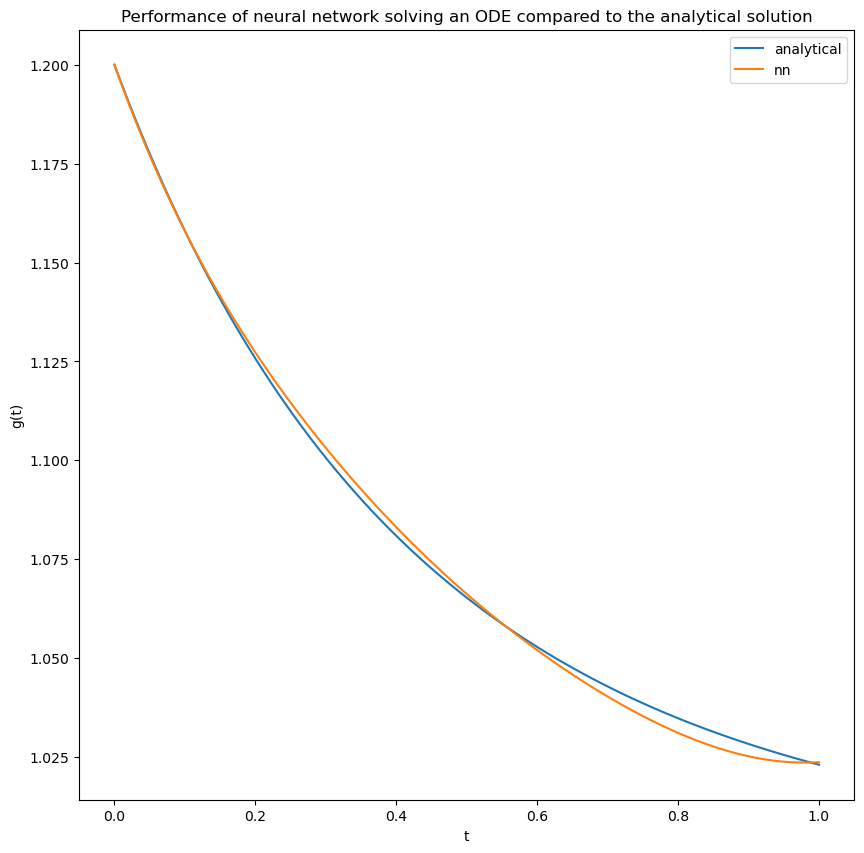

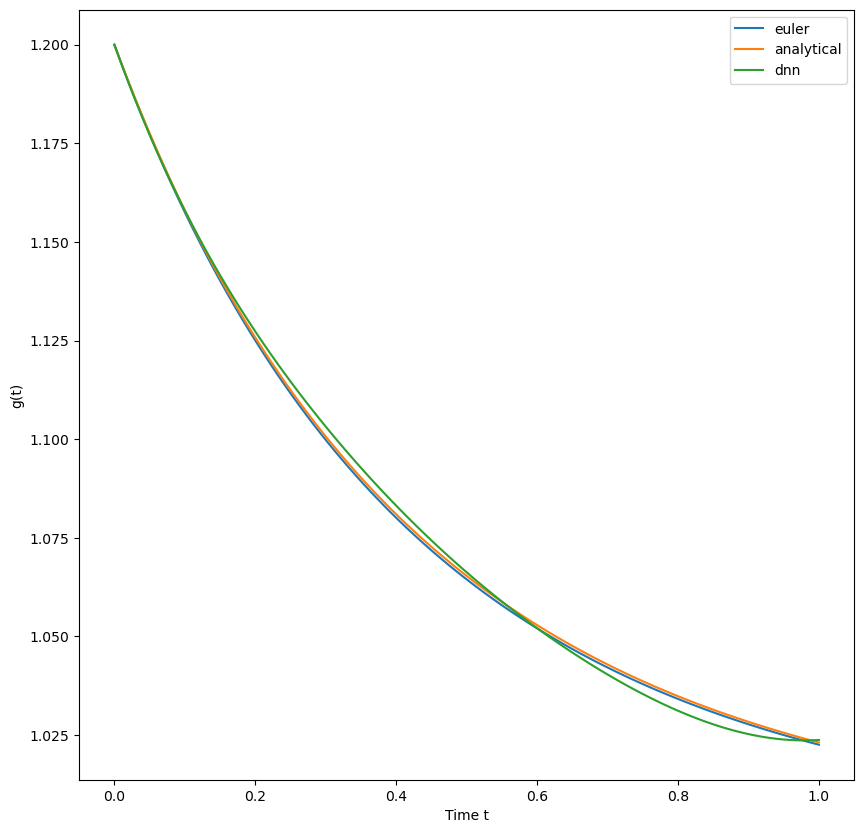

In [6]:
# Assume that all function definitions from the example program using Autograd
# are located here.

if __name__ == '__main__':
    npr.seed(4155)

    ## Decide the vales of arguments to the function to solve
    Nt = 100
    T = 1
    t = np.linspace(0,T, Nt)

    ## Set up the initial parameters
    num_hidden_neurons = [100,50,25]
    num_iter = 1000
    lmb = 1e-3

    P = solve_ode_deep_neural_network(t, num_hidden_neurons, num_iter, lmb)

    g_dnn_ag = g_trial_deep(t,P)
    g_analytical = g_analytic(t)

    # Find the maximum absolute difference between the solutons:
    diff_ag = np.max(np.abs(g_dnn_ag - g_analytical))
    print("The max absolute difference between the solutions is: %g"%diff_ag)

    plt.figure(figsize=(10,10))

    plt.title('Performance of neural network solving an ODE compared to the analytical solution')
    plt.plot(t, g_analytical)
    plt.plot(t, g_dnn_ag[0,:])
    plt.legend(['analytical','nn'])
    plt.xlabel('t')
    plt.ylabel('g(t)')

    ## Find an approximation to the funtion using forward Euler

    alpha, A, g0 = get_parameters()
    dt = T/(Nt - 1)

    # Perform forward Euler to solve the ODE
    g_euler = np.zeros(Nt)
    g_euler[0] = g0

    for i in range(1,Nt):
        g_euler[i] = g_euler[i-1] + dt*(alpha*g_euler[i-1]*(A - g_euler[i-1]))

    # Print the errors done by each method
    diff1 = np.max(np.abs(g_euler - g_analytical))
    diff2 = np.max(np.abs(g_dnn_ag[0,:] - g_analytical))

    print('Max absolute difference between Euler method and analytical: %g'%diff1)
    print('Max absolute difference between deep neural network and analytical: %g'%diff2)

    # Plot results
    plt.figure(figsize=(10,10))

    plt.plot(t,g_euler)
    plt.plot(t,g_analytical)
    plt.plot(t,g_dnn_ag[0,:])

    plt.legend(['euler','analytical','dnn'])
    plt.xlabel('Time t')
    plt.ylabel('g(t)')

    plt.show()

## Example: Solving the one dimensional Poisson equation

The Poisson equation for $g(x)$ in one dimension is

<!-- Equation labels as ordinary links -->
<div id="poisson"></div>

$$
\begin{equation} \label{poisson} \tag{13}
  -g''(x) = f(x)
\end{equation}
$$

where $f(x)$ is a given function for $x \in (0,1)$.

The conditions that $g(x)$ is chosen to fulfill, are

$$
\begin{align*}
  g(0) &= 0 \\
  g(1) &= 0
\end{align*}
$$

This equation can be solved numerically using programs where e.g Autograd and TensorFlow are used.
The results from the networks can then be compared to the analytical solution.
In addition, it could be interesting to see how a typical method for numerically solving second order ODEs compares to the neural networks.

## The specific equation to solve for

Here, the function $g(x)$ to solve for follows the equation

$$
-g''(x) = f(x),\qquad x \in (0,1)
$$

where $f(x)$ is a given function, along with the chosen conditions

<!-- Equation labels as ordinary links -->
<div id="cond"></div>

$$
\begin{aligned}
g(0) = g(1) = 0
\end{aligned}\label{cond} \tag{14}
$$

In this example, we consider the case when $f(x) = (3x + x^2)\exp(x)$.

For this case, a possible trial solution satisfying the conditions could be

$$
g_t(x) = x \cdot (1-x) \cdot N(P,x)
$$

The analytical solution for this problem is

$$
g(x) = x(1 - x)\exp(x)
$$

## Solving the equation using Autograd

Initial cost: 457.256
Final cost: 0.00310113
The max absolute difference between the solutions is: 0.000464088


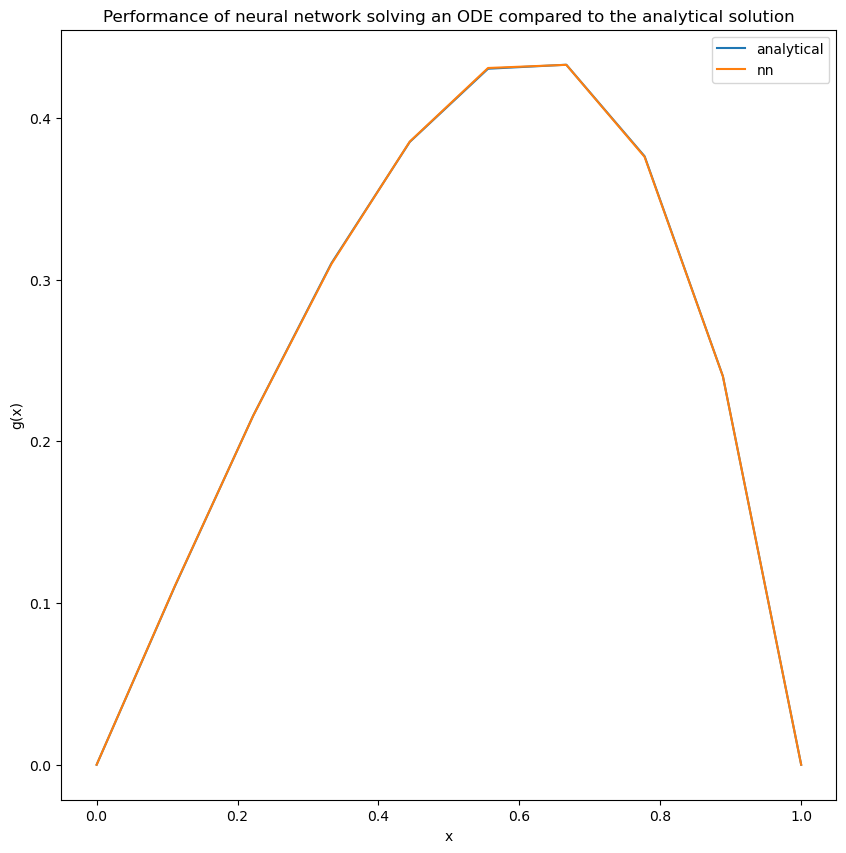

In [7]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def deep_neural_network(deep_params, x):
    # N_hidden is the number of hidden layers
    # deep_params is a list, len() should be used
    N_hidden = len(deep_params) - 1 # -1 since params consists of
                                        # parameters to all the hidden
                                        # layers AND the output layer.

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output


def solve_ode_deep_neural_network(x, num_neurons, num_iter, lmb):
    # num_hidden_neurons is now a list of number of neurons within each hidden layer

    # Find the number of hidden layers:
    N_hidden = np.size(num_neurons)

    ## Set up initial weigths and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 )
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: %g'%cost_function_deep(P, x))

    ## Start finding the optimal weigths using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_deep_grad = grad(cost_function_deep,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of N_hidden + 1 arrays; the gradient w.r.t the weights and biases
        # in the hidden layers and output layers evaluated at x.
        cost_deep_grad =  cost_function_deep_grad(P, x)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_deep_grad[l]

    print('Final cost: %g'%cost_function_deep(P, x))

    return P

## Set up the cost function specified for this Poisson equation:

# The right side of the ODE
def f(x):
    return (3*x + x**2)*np.exp(x)

def cost_function_deep(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial_deep(x,P)

    # Find the derivative w.r.t x of the trial function
    d2_g_t = elementwise_grad(elementwise_grad(g_trial_deep,0))(x,P)

    right_side = f(x)

    err_sqr = (-d2_g_t - right_side)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum/np.size(err_sqr)

# The trial solution:
def g_trial_deep(x,P):
    return x*(1-x)*deep_neural_network(P,x)

# The analytic solution;
def g_analytic(x):
    return x*(1-x)*np.exp(x)

if __name__ == '__main__':
    npr.seed(4155)

    ## Decide the vales of arguments to the function to solve
    Nx = 10
    x = np.linspace(0,1, Nx)

    ## Set up the initial parameters
    num_hidden_neurons = [200,100]
    num_iter = 1000
    lmb = 1e-3

    P = solve_ode_deep_neural_network(x, num_hidden_neurons, num_iter, lmb)

    g_dnn_ag = g_trial_deep(x,P)
    g_analytical = g_analytic(x)

    # Find the maximum absolute difference between the solutons:
    max_diff = np.max(np.abs(g_dnn_ag - g_analytical))
    print("The max absolute difference between the solutions is: %g"%max_diff)

    plt.figure(figsize=(10,10))

    plt.title('Performance of neural network solving an ODE compared to the analytical solution')
    plt.plot(x, g_analytical)
    plt.plot(x, g_dnn_ag[0,:])
    plt.legend(['analytical','nn'])
    plt.xlabel('x')
    plt.ylabel('g(x)')
    plt.show()

## Comparing with a numerical scheme

The Poisson equation is possible to solve using Taylor series to approximate the second derivative.

Using Taylor series, the second derivative can be expressed as

$$
g''(x) = \frac{g(x + \Delta x) - 2g(x) + g(x-\Delta x)}{\Delta x^2} + E_{\Delta x}(x)
$$

where $\Delta x$ is a small step size and $E_{\Delta x}(x)$ being the error term.

Looking away from the error terms gives an approximation to the second derivative:

<!-- Equation labels as ordinary links -->
<div id="approx"></div>

$$
\begin{equation} \label{approx} \tag{15}
g''(x) \approx \frac{g(x + \Delta x) - 2g(x) + g(x-\Delta x)}{\Delta x^2}
\end{equation}
$$

If $x_i = i \Delta x = x_{i-1} + \Delta x$ and $g_i = g(x_i)$ for $i = 1,\dots N_x - 2$ with $N_x$ being the number of values for $x$, ([15](#approx)) becomes

$$
\begin{aligned}
g''(x_i) &\approx \frac{g(x_i + \Delta x) - 2g(x_i) + g(x_i -\Delta x)}{\Delta x^2} \\
&= \frac{g_{i+1} - 2g_i + g_{i-1}}{\Delta x^2}
\end{aligned}
$$

Since we know from our problem that

$$
\begin{aligned}
-g''(x) &= f(x) \\
&= (3x + x^2)\exp(x)
\end{aligned}
$$

along with the conditions $g(0) = g(1) = 0$,
the following scheme can be used to find an approximate solution for $g(x)$ numerically:

<!-- Equation labels as ordinary links -->
<div id="odesys"></div>

$$
\begin{equation}
  \begin{aligned}
  -\Big( \frac{g_{i+1} - 2g_i + g_{i-1}}{\Delta x^2} \Big) &= f(x_i) \\
  -g_{i+1} + 2g_i - g_{i-1} &= \Delta x^2 f(x_i)
  \end{aligned}
\end{equation} \label{odesys} \tag{16}
$$

for $i = 1, \dots, N_x - 2$ where $g_0 = g_{N_x - 1} = 0$ and $f(x_i) = (3x_i + x_i^2)\exp(x_i)$, which is given for our specific problem.

The equation can be rewritten into a matrix equation:

$$
\begin{aligned}
\begin{pmatrix}
2 & -1 & 0 & \dots & 0 \\
-1 & 2 & -1 & \dots & 0 \\
\vdots & & \ddots & & \vdots \\
0 & \dots & -1 & 2 & -1  \\
0 & \dots & 0 & -1 & 2\\
\end{pmatrix}
\begin{pmatrix}
g_1 \\
g_2 \\
\vdots \\
g_{N_x - 3} \\
g_{N_x - 2}
\end{pmatrix}
&=
\Delta x^2
\begin{pmatrix}
f(x_1) \\
f(x_2) \\
\vdots \\
f(x_{N_x - 3}) \\
f(x_{N_x - 2})
\end{pmatrix} \\
\boldsymbol{A}\boldsymbol{g} &= \boldsymbol{f},
\end{aligned}
$$

which makes it possible to solve for the vector $\boldsymbol{g}$.

## Setting up the code

We can then compare the result from this numerical scheme with the output from our network using Autograd:

Initial cost: 465.001
Final cost: 0.00574495
The max absolute difference between the analytical solution and DNN Autograd: 0.000669494
The max absolute difference between the analytical solution and numerical scheme: 2.21015e-05


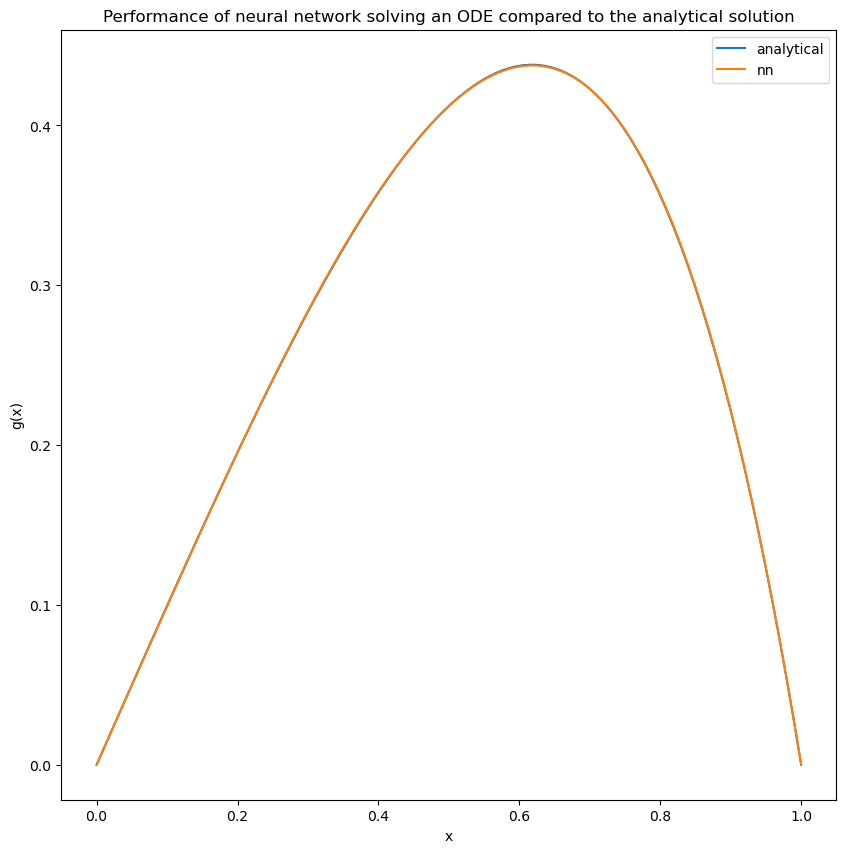

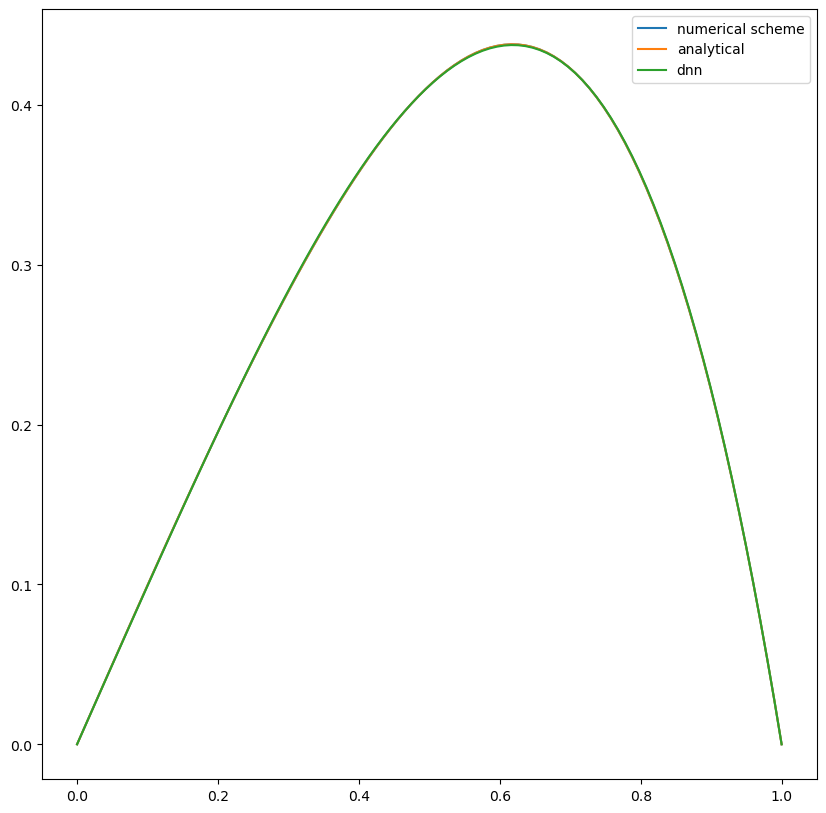

In [9]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def deep_neural_network(deep_params, x):
    # N_hidden is the number of hidden layers
    # deep_params is a list, len() should be used
    N_hidden = len(deep_params) - 1 # -1 since params consists of
                                        # parameters to all the hidden
                                        # layers AND the output layer.

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output


def solve_ode_deep_neural_network(x, num_neurons, num_iter, lmb):
    # num_hidden_neurons is now a list of number of neurons within each hidden layer

    # Find the number of hidden layers:
    N_hidden = np.size(num_neurons)

    ## Set up initial weigths and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 )
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: %g'%cost_function_deep(P, x))

    ## Start finding the optimal weigths using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_deep_grad = grad(cost_function_deep,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of N_hidden + 1 arrays; the gradient w.r.t the weights and biases
        # in the hidden layers and output layers evaluated at x.
        cost_deep_grad =  cost_function_deep_grad(P, x)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_deep_grad[l]

    print('Final cost: %g'%cost_function_deep(P, x))

    return P

## Set up the cost function specified for this Poisson equation:

# The right side of the ODE
def f(x):
    return (3*x + x**2)*np.exp(x)

def cost_function_deep(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial_deep(x,P)

    # Find the derivative w.r.t x of the trial function
    d2_g_t = elementwise_grad(elementwise_grad(g_trial_deep,0))(x,P)

    right_side = f(x)

    err_sqr = (-d2_g_t - right_side)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum/np.size(err_sqr)

# The trial solution:
def g_trial_deep(x,P):
    return x*(1-x)*deep_neural_network(P,x)

# The analytic solution;
def g_analytic(x):
    return x*(1-x)*np.exp(x)

if __name__ == '__main__':
    npr.seed(4155)

    ## Decide the vales of arguments to the function to solve
    Nx = 100
    x = np.linspace(0,1, Nx)

    ## Set up the initial parameters
    num_hidden_neurons = [200,100]
    num_iter = 1000
    lmb = 1e-3

    P = solve_ode_deep_neural_network(x, num_hidden_neurons, num_iter, lmb)

    g_dnn_ag = g_trial_deep(x,P)
    g_analytical = g_analytic(x)

    # Find the maximum absolute difference between the solutons:

    plt.figure(figsize=(10,10))

    plt.title('Performance of neural network solving an ODE compared to the analytical solution')
    plt.plot(x, g_analytical)
    plt.plot(x, g_dnn_ag[0,:])
    plt.legend(['analytical','nn'])
    plt.xlabel('x')
    plt.ylabel('g(x)')

    ## Perform the computation using the numerical scheme

    dx = 1/(Nx - 1)

    # Set up the matrix A
    A = np.zeros((Nx-2,Nx-2))

    A[0,0] = 2
    A[0,1] = -1

    for i in range(1,Nx-3):
        A[i,i-1] = -1
        A[i,i] = 2
        A[i,i+1] = -1

    A[Nx - 3, Nx - 4] = -1
    A[Nx - 3, Nx - 3] = 2

    # Set up the vector f
    f_vec = dx**2 * f(x[1:-1])

    # Solve the equation
    g_res = np.linalg.solve(A,f_vec)

    g_vec = np.zeros(Nx)
    g_vec[1:-1] = g_res

    # Print the differences between each method
    max_diff1 = np.max(np.abs(g_dnn_ag - g_analytical))
    max_diff2 = np.max(np.abs(g_vec - g_analytical))
    print("The max absolute difference between the analytical solution and DNN Autograd: %g"%max_diff1)
    print("The max absolute difference between the analytical solution and numerical scheme: %g"%max_diff2)

    # Plot the results
    plt.figure(figsize=(10,10))

    plt.plot(x,g_vec)
    plt.plot(x,g_analytical)
    plt.plot(x,g_dnn_ag[0,:])

    plt.legend(['numerical scheme','analytical','dnn'])
    plt.show()

## Partial Differential Equations

A partial differential equation (PDE) has a solution here the function
is defined by multiple variables.  The equation may involve all kinds
of combinations of which variables the function is differentiated with
respect to.

In general, a partial differential equation for a function $g(x_1,\dots,x_N)$ with $N$ variables may be expressed as

<!-- Equation labels as ordinary links -->
<div id="PDE"></div>

$$
\begin{equation} \label{PDE} \tag{17}
  f\left(x_1, \, \dots \, , x_N, \frac{\partial g(x_1,\dots,x_N) }{\partial x_1}, \dots , \frac{\partial g(x_1,\dots,x_N) }{\partial x_N}, \frac{\partial g(x_1,\dots,x_N) }{\partial x_1\partial x_2}, \, \dots \, , \frac{\partial^n g(x_1,\dots,x_N) }{\partial x_N^n} \right) = 0
\end{equation}
$$

where $f$ is an expression involving all kinds of possible mixed derivatives of $g(x_1,\dots,x_N)$ up to an order $n$. In order for the solution to be unique, some additional conditions must also be given.

## Type of problem

The problem our network must solve for, is similar to the ODE case.
We must have a trial solution $g_t$ at hand.

For instance, the trial solution could be expressed as

$$
\begin{align*}
  g_t(x_1,\dots,x_N) = h_1(x_1,\dots,x_N) + h_2(x_1,\dots,x_N,N(x_1,\dots,x_N,P))
\end{align*}
$$

where $h_1(x_1,\dots,x_N)$ is a function that ensures $g_t(x_1,\dots,x_N)$ satisfies some given conditions.
The neural network $N(x_1,\dots,x_N,P)$ has weights and biases described by $P$ and $h_2(x_1,\dots,x_N,N(x_1,\dots,x_N,P))$ is an expression using the output from the neural network in some way.

The role of the function $h_2(x_1,\dots,x_N,N(x_1,\dots,x_N,P))$, is to ensure that the output of $N(x_1,\dots,x_N,P)$ is zero when $g_t(x_1,\dots,x_N)$ is evaluated at the values of $x_1,\dots,x_N$ where the given conditions must be satisfied. The function $h_1(x_1,\dots,x_N)$ should alone make $g_t(x_1,\dots,x_N)$ satisfy the conditions.

## Network requirements

The network tries then the minimize the cost function following the
same ideas as described for the ODE case, but now with more than one
variables to consider.  The concept still remains the same; find a set
of parameters $P$ such that the expression $f$ in ([17](#PDE)) is as
close to zero as possible.

As for the ODE case, the cost function is the mean squared error that
the network must try to minimize. The cost function for the network to
minimize is

$$
C\left(x_1, \dots, x_N, P\right) = \left(  f\left(x_1, \, \dots \, , x_N, \frac{\partial g(x_1,\dots,x_N) }{\partial x_1}, \dots , \frac{\partial g(x_1,\dots,x_N) }{\partial x_N}, \frac{\partial g(x_1,\dots,x_N) }{\partial x_1\partial x_2}, \, \dots \, , \frac{\partial^n g(x_1,\dots,x_N) }{\partial x_N^n} \right) \right)^2
$$

## More details

If we let $\boldsymbol{x} = \big( x_1, \dots, x_N \big)$ be an array containing the values for $x_1, \dots, x_N$ respectively, the cost function can be reformulated into the following:

$$
C\left(\boldsymbol{x}, P\right) = f\left( \left( \boldsymbol{x}, \frac{\partial g(\boldsymbol{x}) }{\partial x_1}, \dots , \frac{\partial g(\boldsymbol{x}) }{\partial x_N}, \frac{\partial g(\boldsymbol{x}) }{\partial x_1\partial x_2}, \, \dots \, , \frac{\partial^n g(\boldsymbol{x}) }{\partial x_N^n} \right) \right)^2
$$

If we also have $M$ different sets of values for $x_1, \dots, x_N$, that is $\boldsymbol{x}_i = \big(x_1^{(i)}, \dots, x_N^{(i)}\big)$ for $i = 1,\dots,M$ being the rows in matrix $X$, the cost function can be generalized into

$$
C\left(X, P \right) = \sum_{i=1}^M f\left( \left( \boldsymbol{x}_i, \frac{\partial g(\boldsymbol{x}_i) }{\partial x_1}, \dots , \frac{\partial g(\boldsymbol{x}_i) }{\partial x_N}, \frac{\partial g(\boldsymbol{x}_i) }{\partial x_1\partial x_2}, \, \dots \, , \frac{\partial^n g(\boldsymbol{x}_i) }{\partial x_N^n} \right) \right)^2.
$$

## Example: The diffusion equation

In one spatial dimension, the equation reads

$$
\frac{\partial g(x,t)}{\partial t} = \frac{\partial^2 g(x,t)}{\partial x^2}
$$

where a possible choice of conditions are

$$
\begin{align*}
g(0,t) &= 0 ,\qquad t \geq 0 \\
g(1,t) &= 0, \qquad t \geq 0 \\
g(x,0) &= u(x),\qquad x\in [0,1]
\end{align*}
$$

with $u(x)$ being some given function.

## Defining the problem

For this case, we want to find $g(x,t)$ such that

<!-- Equation labels as ordinary links -->
<div id="diffonedim"></div>

$$
\begin{equation}
  \frac{\partial g(x,t)}{\partial t} = \frac{\partial^2 g(x,t)}{\partial x^2}
\end{equation} \label{diffonedim} \tag{18}
$$

and

$$
\begin{align*}
g(0,t) &= 0 ,\qquad t \geq 0 \\
g(1,t) &= 0, \qquad t \geq 0 \\
g(x,0) &= u(x),\qquad x\in [0,1]
\end{align*}
$$

with $u(x) = \sin(\pi x)$.

First, let us set up the deep neural network.
The deep neural network will follow the same structure as discussed in the examples solving the ODEs.
First, we will look into how Autograd could be used in a network tailored to solve for bivariate functions.

## Setting up the network using Autograd

The only change to do here, is to extend our network such that
functions of multiple parameters are correctly handled.  In this case
we have two variables in our function to solve for, that is time $t$
and position $x$.  The variables will be represented by a
one-dimensional array in the program.  The program will evaluate the
network at each possible pair $(x,t)$, given an array for the desired
$x$-values and $t$-values to approximate the solution at.

In [7]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def deep_neural_network(deep_params, x):
    # x is now a point and a 1D numpy array; make it a column vector
    num_coordinates = np.size(x,0)
    x = x.reshape(num_coordinates,-1)

    num_points = np.size(x,1)

    # N_hidden is the number of hidden layers
    N_hidden = len(deep_params) - 1 # -1 since params consist of parameters to all the hidden layers AND the output layer

    # Assume that the input layer does nothing to the input x
    x_input = x
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_points)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_points)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output[0][0]

## Setting up the network using Autograd; The trial solution

The cost function must then iterate through the given arrays
containing values for $x$ and $t$, defines a point $(x,t)$ the deep
neural network and the trial solution is evaluated at, and then finds
the Jacobian of the trial solution.

A possible trial solution for this PDE is

$$
g_t(x,t) = h_1(x,t) + x(1-x)tN(x,t,P)
$$

with $h_1(x,t)$ being a function ensuring that $g_t(x,t)$ satisfies our given conditions, and $N(x,t,P)$ being the output from the deep neural network using weights and biases for each layer from $P$.

To fulfill the conditions, $h_1(x,t)$ could be:

$$
h_1(x,t) = (1-t)\Big(u(x) - \big((1-x)u(0) + x u(1)\big)\Big) = (1-t)u(x) = (1-t)\sin(\pi x)
$$
since $(0) = u(1) = 0$ and $u(x) = \sin(\pi x)$.

## Why the Jacobian?

The Jacobian is used because the program must find the derivative of
the trial solution with respect to $x$ and $t$.

This gives the necessity of computing the Jacobian matrix, as we want
to evaluate the gradient with respect to $x$ and $t$ (note that the
Jacobian of a scalar-valued multivariate function is simply its
gradient).

In Autograd, the differentiation is by default done with respect to
the first input argument of your Python function. Since the points is
an array representing $x$ and $t$, the Jacobian is calculated using
the values of $x$ and $t$.

To find the second derivative with respect to $x$ and $t$, the
Jacobian can be found for the second time. The result is a Hessian
matrix, which is the matrix containing all the possible second order
mixed derivatives of $g(x,t)$.

In [8]:
# Set up the trial function:
def u(x):
    return np.sin(np.pi*x)

def g_trial(point,P):
    x,t = point
    return (1-t)*u(x) + x*(1-x)*t*deep_neural_network(P,point)

# The right side of the ODE:
def f(point):
    return 0.

# The cost function:
def cost_function(P, x, t):
    cost_sum = 0

    g_t_jacobian_func = jacobian(g_trial)
    g_t_hessian_func = hessian(g_trial)

    for x_ in x:
        for t_ in t:
            point = np.array([x_,t_])

            g_t = g_trial(point,P)
            g_t_jacobian = g_t_jacobian_func(point,P)
            g_t_hessian = g_t_hessian_func(point,P)

            g_t_dt = g_t_jacobian[1]
            g_t_d2x = g_t_hessian[0][0]

            func = f(point)

            err_sqr = ( (g_t_dt - g_t_d2x) - func)**2
            cost_sum += err_sqr

    return cost_sum

## Setting up the network using Autograd; The full program

Having set up the network, along with the trial solution and cost function, we can now see how the deep neural network performs by comparing the results to the analytical solution.

The analytical solution of our problem is

$$
g(x,t) = \exp(-\pi^2 t)\sin(\pi x)
$$

A possible way to implement a neural network solving the PDE, is given below.
Be aware, though, that it is fairly slow for the parameters used.
A better result is possible, but requires more iterations, and thus longer time to complete.

Indeed, the program below is not optimal in its implementation, but rather serves as an example on how to implement and use a neural network to solve a PDE.
Using TensorFlow results in a much better execution time. Try it!

In [9]:
import autograd.numpy as np
from autograd import jacobian,hessian,grad
import autograd.numpy.random as npr
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

## Set up the network

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def deep_neural_network(deep_params, x):
    # x is now a point and a 1D numpy array; make it a column vector
    num_coordinates = np.size(x,0)
    x = x.reshape(num_coordinates,-1)

    num_points = np.size(x,1)

    # N_hidden is the number of hidden layers
    N_hidden = len(deep_params) - 1 # -1 since params consist of parameters to all the hidden layers AND the output layer

    # Assume that the input layer does nothing to the input x
    x_input = x
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_points)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_points)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output[0][0]

## Define the trial solution and cost function
def u(x):
    return np.sin(np.pi*x)

def g_trial(point,P):
    x,t = point
    return (1-t)*u(x) + x*(1-x)*t*deep_neural_network(P,point)

# The right side of the ODE:
def f(point):
    return 0.

# The cost function:
def cost_function(P, x, t):
    cost_sum = 0

    g_t_jacobian_func = jacobian(g_trial)
    g_t_hessian_func = hessian(g_trial)

    for x_ in x:
        for t_ in t:
            point = np.array([x_,t_])

            g_t = g_trial(point,P)
            g_t_jacobian = g_t_jacobian_func(point,P)
            g_t_hessian = g_t_hessian_func(point,P)

            g_t_dt = g_t_jacobian[1]
            g_t_d2x = g_t_hessian[0][0]

            func = f(point)

            err_sqr = ( (g_t_dt - g_t_d2x) - func)**2
            cost_sum += err_sqr

    return cost_sum /( np.size(x)*np.size(t) )

## For comparison, define the analytical solution
def g_analytic(point):
    x,t = point
    return np.exp(-np.pi**2*t)*np.sin(np.pi*x)

## Set up a function for training the network to solve for the equation
def solve_pde_deep_neural_network(x,t, num_neurons, num_iter, lmb):
    ## Set up initial weigths and biases
    N_hidden = np.size(num_neurons)

    ## Set up initial weigths and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 + 1 ) # 2 since we have two points, +1 to include bias
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: ',cost_function(P, x, t))

    cost_function_grad = grad(cost_function,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        cost_grad =  cost_function_grad(P, x , t)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_grad[l]

    print('Final cost: ',cost_function(P, x, t))

    return P

if __name__ == '__main__':
    ### Use the neural network:
    npr.seed(15)

    ## Decide the vales of arguments to the function to solve
    Nx = 10; Nt = 10
    x = np.linspace(0, 1, Nx)
    t = np.linspace(0,1,Nt)

    ## Set up the parameters for the network
    num_hidden_neurons = [100, 25]
    num_iter = 250
    lmb = 0.01

    P = solve_pde_deep_neural_network(x,t, num_hidden_neurons, num_iter, lmb)

    ## Store the results
    g_dnn_ag = np.zeros((Nx, Nt))
    G_analytical = np.zeros((Nx, Nt))
    for i,x_ in enumerate(x):
        for j, t_ in enumerate(t):
            point = np.array([x_, t_])
            g_dnn_ag[i,j] = g_trial(point,P)

            G_analytical[i,j] = g_analytic(point)

    # Find the map difference between the analytical and the computed solution
    diff_ag = np.abs(g_dnn_ag - G_analytical)
    print('Max absolute difference between the analytical solution and the network: %g'%np.max(diff_ag))

    ## Plot the solutions in two dimensions, that being in position and time

    T,X = np.meshgrid(t,x)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_suplot(projection='3d')
    ax.set_title('Solution from the deep neural network w/ %d layer'%len(num_hidden_neurons))
    s = ax.plot_surface(T,X,g_dnn_ag,linewidth=0,antialiased=False,cmap=cm.viridis)
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Position $x$');


    fig = plt.figure(figsize=(10,10))
    ax = fig.add_suplot(projection='3d')
    ax.set_title('Analytical solution')
    s = ax.plot_surface(T,X,G_analytical,linewidth=0,antialiased=False,cmap=cm.viridis)
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Position $x$');

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_suplot(projection='3d')
    ax.set_title('Difference')
    s = ax.plot_surface(T,X,diff_ag,linewidth=0,antialiased=False,cmap=cm.viridis)
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Position $x$');

    ## Take some slices of the 3D plots just to see the solutions at particular times
    indx1 = 0
    indx2 = int(Nt/2)
    indx3 = Nt-1

    t1 = t[indx1]
    t2 = t[indx2]
    t3 = t[indx3]

    # Slice the results from the DNN
    res1 = g_dnn_ag[:,indx1]
    res2 = g_dnn_ag[:,indx2]
    res3 = g_dnn_ag[:,indx3]

    # Slice the analytical results
    res_analytical1 = G_analytical[:,indx1]
    res_analytical2 = G_analytical[:,indx2]
    res_analytical3 = G_analytical[:,indx3]

    # Plot the slices
    plt.figure(figsize=(10,10))
    plt.title("Computed solutions at time = %g"%t1)
    plt.plot(x, res1)
    plt.plot(x,res_analytical1)
    plt.legend(['dnn','analytical'])

    plt.figure(figsize=(10,10))
    plt.title("Computed solutions at time = %g"%t2)
    plt.plot(x, res2)
    plt.plot(x,res_analytical2)
    plt.legend(['dnn','analytical'])

    plt.figure(figsize=(10,10))
    plt.title("Computed solutions at time = %g"%t3)
    plt.plot(x, res3)
    plt.plot(x,res_analytical3)
    plt.legend(['dnn','analytical'])

    plt.show()

## Resources on differential equations and deep learning

1. [Artificial neural networks for solving ordinary and partial differential equations by I.E. Lagaris et al](https://pdfs.semanticscholar.org/d061/df393e0e8fbfd0ea24976458b7d42419040d.pdf)

2. [Neural networks for solving differential equations by A. Honchar](https://becominghuman.ai/neural-networks-for-solving-differential-equations-fa230ac5e04c)

3. [Solving differential equations using neural networks by M.M Chiaramonte and M. Kiener](http://cs229.stanford.edu/proj2013/ChiaramonteKiener-SolvingDifferentialEquationsUsingNeuralNetworks.pdf)

4. [Introduction to Partial Differential Equations by A. Tveito, R. Winther](https://www.springer.com/us/book/9783540225515)

## Convolutional Neural Networks (recognizing images)

Convolutional neural networks (CNNs) were developed during the last
decade of the previous century, with a focus on character recognition
tasks. Nowadays, CNNs are a central element in the spectacular success
of deep learning methods. The success in for example image
classifications have made them a central tool for most machine
learning practitioners.

CNNs are very similar to ordinary Neural Networks.
They are made up of neurons that have learnable weights and
biases. Each neuron receives some inputs, performs a dot product and
optionally follows it with a non-linearity. The whole network still
expresses a single differentiable score function: from the raw image
pixels on one end to class scores at the other. And they still have a
loss function (for example Softmax) on the last (fully-connected) layer
and all the tips/tricks we developed for learning regular Neural
Networks still apply (back propagation, gradient descent etc etc).

## What is the Difference

**CNN architectures make the explicit assumption that
the inputs are images, which allows us to encode certain properties
into the architecture. These then make the forward function more
efficient to implement and vastly reduce the amount of parameters in
the network.**

## Neural Networks vs CNNs

Neural networks are defined as **affine transformations**, that is 
a vector is received as input and is multiplied with a matrix of so-called weights (our unknown paramters) to produce an
output (to which a bias vector is usually added before passing the result
through a nonlinear activation function). This is applicable to any type of input, be it an
image, a sound clip or an unordered collection of features: whatever their
dimensionality, their representation can always be flattened into a vector
before the transformation.

## Why CNNS for images, sound files, medical images from CT scans etc?

However, when we consider images, sound clips and many other similar kinds of data, these data  have an intrinsic
structure. More formally, they share these important properties:
* They are stored as multi-dimensional arrays (think of the pixels of a figure) .

* They feature one or more axes for which ordering matters (e.g., width and height axes for an image, time axis for a sound clip).

* One axis, called the channel axis, is used to access different views of the data (e.g., the red, green and blue channels of a color image, or the left and right channels of a stereo audio track).

These properties are not exploited when an affine transformation is applied; in
fact, all the axes are treated in the same way and the topological information
is not taken into account. Still, taking advantage of the implicit structure of
the data may prove very handy in solving some tasks, like computer vision and
speech recognition, and in these cases it would be best to preserve it. This is
where discrete convolutions come into play.

A discrete convolution is a linear transformation that preserves this notion of
ordering. It is sparse (only a few input units contribute to a given output
unit) and reuses parameters (the same weights are applied to multiple locations
in the input).

## Regular NNs don’t scale well to full images

As an example, consider
an image of size $32\times 32\times 3$ (32 wide, 32 high, 3 color channels), so a
single fully-connected neuron in a first hidden layer of a regular
Neural Network would have $32\times 32\times 3 = 3072$ weights. This amount still
seems manageable, but clearly this fully-connected structure does not
scale to larger images. For example, an image of more respectable
size, say $200\times 200\times 3$, would lead to neurons that have 
$200\times 200\times 3 = 120,000$ weights. 

We could have
several such neurons, and the parameters would add up quickly! Clearly,
this full connectivity is wasteful and the huge number of parameters
would quickly lead to possible overfitting.

<!-- dom:FIGURE: [figslides/nn.jpeg, width=500 frac=0.6]  A regular 3-layer Neural Network. -->
<!-- begin figure -->

<img src="figslides/nn.jpeg" width="500"><p style="font-size: 0.9em"><i>Figure 1: A regular 3-layer Neural Network.</i></p>
<!-- end figure -->

## 3D volumes of neurons

Convolutional Neural Networks take advantage of the fact that the
input consists of images and they constrain the architecture in a more
sensible way. 

In particular, unlike a regular Neural Network, the
layers of a CNN have neurons arranged in 3 dimensions: width,
height, depth. (Note that the word depth here refers to the third
dimension of an activation volume, not to the depth of a full Neural
Network, which can refer to the total number of layers in a network.)

To understand it better, the above example of an image 
with an input volume of
activations has dimensions $32\times 32\times 3$ (width, height,
depth respectively). 

The neurons in a layer will
only be connected to a small region of the layer before it, instead of
all of the neurons in a fully-connected manner. Moreover, the final
output layer could  for this specific image have dimensions $1\times 1 \times 10$, 
because by the
end of the CNN architecture we will reduce the full image into a
single vector of class scores, arranged along the depth
dimension. 

<!-- dom:FIGURE: [figslides/cnn.jpeg, width=500 frac=0.6]  A CNN arranges its neurons in three dimensions (width, height, depth), as visualized in one of the layers. Every layer of a CNN transforms the 3D input volume to a 3D output volume of neuron activations. In this example, the red input layer holds the image, so its width and height would be the dimensions of the image, and the depth would be 3 (Red, Green, Blue channels). -->
<!-- begin figure -->

<img src="figslides/cnn.jpeg" width="500"><p style="font-size: 0.9em"><i>Figure 1: A CNN arranges its neurons in three dimensions (width, height, depth), as visualized in one of the layers. Every layer of a CNN transforms the 3D input volume to a 3D output volume of neuron activations. In this example, the red input layer holds the image, so its width and height would be the dimensions of the image, and the depth would be 3 (Red, Green, Blue channels).</i></p>
<!-- end figure -->

## More on Dimensionalities

In fields like signal processing (and imaging as well), one designs
so-called filters. These filters are defined by the convolutions and
are often hand-crafted. One may specify filters for smoothing, edge
detection, frequency reshaping, and similar operations. However with
neural networks the idea is to automatically learn the filters and use
many of them in conjunction with non-linear operations (activation
functions).

As an example consider a neural network operating on sound sequence
data.  Assume that we an input vector $\boldsymbol{x}$ of length $d=10^6$.  We
construct then a neural network with onle hidden layer only with
$10^4$ nodes. This means that we will have a weight matrix with
$10^4\times 10^6=10^{10}$ weights to be determined, together with $10^4$ biases.

Assume furthermore that we have an output layer which is meant to train whether the sound sequence represents a human voice (true) or something else (false).
It means that we have only one output node. But since this output node connects to $10^4$ nodes in the hidden layer, there are in total $10^4$ weights to be determined for the output layer, plus one bias. In total we have

$$
\mathrm{NumberParameters}=10^{10}+10^4+10^4+1 \approx 10^{10},
$$

that is ten billion parameters to determine.

## Further remarks

The main principles that justify convolutions is locality of
information and repetion of patterns within the signal. Sound samples
of the input in adjacent spots are much more likely to affect each
other than those that are very far away. Similarly, sounds are
repeated in multiple times in the signal. While slightly simplistic,
reasoning about such a sound example demonstrates this. The same
principles then apply to images and other similar data.

## Layers used to build CNNs

A simple CNN is a sequence of layers, and every layer of a CNN
transforms one volume of activations to another through a
differentiable function. We use three main types of layers to build
CNN architectures: Convolutional Layer, Pooling Layer, and
Fully-Connected Layer (exactly as seen in regular Neural Networks). We
will stack these layers to form a full CNN architecture.

A simple CNN for image classification could have the architecture:

* **INPUT** ($32\times 32 \times 3$) will hold the raw pixel values of the image, in this case an image of width 32, height 32, and with three color channels R,G,B.

* **CONV** (convolutional )layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as $[32\times 32\times 12]$ if we decided to use 12 filters.

* **RELU** layer will apply an elementwise activation function, such as the $max(0,x)$ thresholding at zero. This leaves the size of the volume unchanged ($[32\times 32\times 12]$).

* **POOL** (pooling) layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as $[16\times 16\times 12]$.

* **FC** (i.e. fully-connected) layer will compute the class scores, resulting in volume of size $[1\times 1\times 10]$, where each of the 10 numbers correspond to a class score, such as among the 10 categories of the MNIST images we considered above . As with ordinary Neural Networks and as the name implies, each neuron in this layer will be connected to all the numbers in the previous volume.

## Transforming images

CNNs transform the original image layer by layer from the original
pixel values to the final class scores. 

Observe that some layers contain
parameters and other don’t. In particular, the CNN layers perform
transformations that are a function of not only the activations in the
input volume, but also of the parameters (the weights and biases of
the neurons). On the other hand, the RELU/POOL layers will implement a
fixed function. The parameters in the CONV/FC layers will be trained
with gradient descent so that the class scores that the CNN computes
are consistent with the labels in the training set for each image.

## CNNs in brief

In summary:

* A CNN architecture is in the simplest case a list of Layers that transform the image volume into an output volume (e.g. holding the class scores)

* There are a few distinct types of Layers (e.g. CONV/FC/RELU/POOL are by far the most popular)

* Each Layer accepts an input 3D volume and transforms it to an output 3D volume through a differentiable function

* Each Layer may or may not have parameters (e.g. CONV/FC do, RELU/POOL don’t)

* Each Layer may or may not have additional hyperparameters (e.g. CONV/FC/POOL do, RELU doesn’t)

## A deep CNN model ([From Raschka et al](https://github.com/rasbt/machine-learning-book))

<!-- dom:FIGURE: [figslides/deepcnn.png, width=500 frac=0.67]  A deep CNN -->
<!-- begin figure -->

<img src="figslides/deepcnn.png" width="500"><p style="font-size: 0.9em"><i>Figure 1: A deep CNN</i></p>
<!-- end figure -->

## Key Idea

A dense neural network is representd by an affine operation (like
matrix-matrix multiplication) where all parameters are included.

The key idea in CNNs for say imaging is that in images neighbor pixels tend to be related! So we connect
only neighboring neurons in the input instead of connecting all with the first hidden layer.

We say we perform a filtering (convolution is the mathematical operation).

## How to do image compression before the era of deep learning

The singular-value decomposition (SVD) algorithm has been for decades one of the standard ways of compressing images.
The [lectures on the SVD](https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/chapter2.html#the-singular-value-decomposition) give many of the essential details concerning the SVD.

The orthogonal vectors which are obtained from the SVD, can be used to
project down the dimensionality of a given image. In the example here
we gray-scale an image and downsize it.

This recipe relies on us being able to actually perform the SVD. For
large images, and in particular with many images to reconstruct, using the SVD 
may quickly become an overwhelming task. With the advent of efficient deep
learning methods like CNNs and later generative methods, these methods
have become in the last years the premier way of performing image
analysis. In particular for classification problems with labelled images.

## The SVD example

In [10]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import scipy.linalg as ln
import numpy as np
import os
from PIL import Image
from math import log10, sqrt 
plt.rcParams['figure.figsize'] = [16, 8]
# Import image
A = imread(os.path.join("figslides/photo1.jpg"))
X = A.dot([0.299, 0.5870, 0.114]) # Convert RGB to grayscale
img = plt.imshow(X)
# convert to gray
img.set_cmap('gray')
plt.axis('off')
plt.show()
# Call image size
print(': %s'%str(X.shape))


# split the matrix into U, S, VT
U, S, VT = np.linalg.svd(X,full_matrices=False)
S = np.diag(S)
m = 800 # Image's width
n = 1200 # Image's height
j = 0
# Try compression with different k vectors (these represent projections):
for k in (5,10, 20, 100,200,400,500):
    # Original size of the image
    originalSize = m * n 
    # Size after compressed
    compressedSize = k * (1 + m + n) 
    # The projection of the original image
    Xapprox = U[:,:k] @ S[0:k,:k] @ VT[:k,:]
    plt.figure(j+1)
    j += 1
    img = plt.imshow(Xapprox)
    img.set_cmap('gray')
    
    plt.axis('off')
    plt.title('k = ' + str(k))
    plt.show() 
    print('Original size of image:')
    print(originalSize)
    print('Compression rate as Compressed image / Original size:')
    ratio = compressedSize * 1.0 / originalSize
    print(ratio)
    print('Compression rate is ' + str( round(ratio * 100 ,2)) + '%' )  
    # Estimate MQA
    x= X.astype("float")
    y=Xapprox.astype("float")
    err = np.sum((x - y) ** 2)
    err /= float(X.shape[0] * Xapprox.shape[1])
    print('The mean-square deviation '+ str(round( err)))
    max_pixel = 255.0
    # Estimate Signal Noise Ratio
    srv = 20 * (log10(max_pixel / sqrt(err)))
    print('Signa to noise ratio '+ str(round(srv)) +'dB')

## Mathematics of CNNs

The mathematics of CNNs is based on the mathematical operation of
**convolution**.  In mathematics (in particular in functional analysis),
convolution is represented by mathematical operations (integration,
summation etc) on two functions in order to produce a third function
that expresses how the shape of one gets modified by the other.
Convolution has a plethora of applications in a variety of
disciplines, spanning from statistics to signal processing, computer
vision, solutions of differential equations,linear algebra,
engineering, and yes, machine learning.

Mathematically, convolution is defined as follows (one-dimensional example):
Let us define a continuous function $y(t)$ given by

$$
y(t) = \int x(a) w(t-a) da,
$$

where $x(a)$ represents a so-called input and $w(t-a)$ is normally called the weight function or kernel.

The above integral is written in  a more compact form as

$$
y(t) = \left(x * w\right)(t).
$$

The discretized version reads

$$
y(t) = \sum_{a=-\infty}^{a=\infty}x(a)w(t-a).
$$

Computing the inverse of the above convolution operations is known as deconvolution and the process is commutative.

How can we use this? And what does it mean? Let us study some familiar examples first.

## Convolution Examples: Polynomial multiplication

Our first example is that of a multiplication between two polynomials,
which we will rewrite in terms of the mathematics of convolution. In
the final stage, since the problem here is a discrete one, we will
recast the final expression in terms of a matrix-vector
multiplication, where the matrix is a so-called [Toeplitz matrix
](https://link.springer.com/book/10.1007/978-93-86279-04-0).

Let us look a the following polynomials to second and third order, respectively:

$$
p(t) = \alpha_0+\alpha_1 t+\alpha_2 t^2,
$$

and

$$
s(t) = \beta_0+\beta_1 t+\beta_2 t^2+\beta_3 t^3.
$$

The polynomial multiplication gives us a new polynomial of degree $5$

$$
z(t) = \delta_0+\delta_1 t+\delta_2 t^2+\delta_3 t^3+\delta_4 t^4+\delta_5 t^5.
$$

## Efficient Polynomial Multiplication

Computing polynomial products can be implemented efficiently if we rewrite the more brute force multiplications using convolution.
We note first that the new coefficients are given as

$$
\begin{split}
\delta_0=&\alpha_0\beta_0\\
\delta_1=&\alpha_1\beta_0+\alpha_0\beta_1\\
\delta_2=&\alpha_0\beta_2+\alpha_1\beta_1+\alpha_2\beta_0\\
\delta_3=&\alpha_1\beta_2+\alpha_2\beta_1+\alpha_0\beta_3\\
\delta_4=&\alpha_2\beta_2+\alpha_1\beta_3\\
\delta_5=&\alpha_2\beta_3.\\
\end{split}
$$

We note that $\alpha_i=0$ except for $i\in \left\{0,1,2\right\}$ and $\beta_i=0$ except for $i\in\left\{0,1,2,3\right\}$.

We can then rewrite the coefficients $\delta_j$ using a discrete convolution as

$$
\delta_j = \sum_{i=-\infty}^{i=\infty}\alpha_i\beta_{j-i}=(\alpha * \beta)_j,
$$

or as a double sum with restriction $l=i+j$

$$
\delta_l = \sum_{ij}\alpha_i\beta_{j}.
$$

## Further simplification

Although we may have redundant operations with some few zeros for $\beta_i$, we can rewrite the above sum in a more compact way as

$$
\delta_i = \sum_{k=0}^{k=m-1}\alpha_k\beta_{i-k},
$$

where $m=3$ in our case, the maximum length of
the vector $\alpha$. Note that the vector $\boldsymbol{\beta}$ has length $n=4$. Below we will find an even more efficient representation.

## A more efficient way of coding the above Convolution

Since we only have a finite number of $\alpha$ and $\beta$ values
which are non-zero, we can rewrite the above convolution expressions
as a matrix-vector multiplication

$$
\boldsymbol{\delta}=\begin{bmatrix}\alpha_0 & 0 & 0 & 0 \\
                            \alpha_1 & \alpha_0 & 0 & 0 \\
			    \alpha_2 & \alpha_1 & \alpha_0 & 0 \\
			    0 & \alpha_2 & \alpha_1 & \alpha_0 \\
			    0 & 0 & \alpha_2 & \alpha_1 \\
			    0 & 0 & 0 & \alpha_2
			    \end{bmatrix}\begin{bmatrix} \beta_0 \\ \beta_1 \\ \beta_2 \\ \beta_3\end{bmatrix}.
$$

## Commutative process

The process is commutative and we can easily see that we can rewrite the multiplication in terms of  a matrix holding $\beta$ and a vector holding $\alpha$.
In this case we have

$$
\boldsymbol{\delta}=\begin{bmatrix}\beta_0 & 0 & 0  \\
                            \beta_1 & \beta_0 & 0  \\
			    \beta_2 & \beta_1 & \beta_0  \\
			    \beta_3 & \beta_2 & \beta_1 \\
			    0 & \beta_3 & \beta_2 \\
			    0 & 0 & \beta_3
			    \end{bmatrix}\begin{bmatrix} \alpha_0 \\ \alpha_1 \\ \alpha_2\end{bmatrix}.
$$

Note that the use of these matrices is for mathematical purposes only
and not implementation purposes.  When implementing the above equation
we do not encode (and allocate memory) the matrices explicitely.  We
rather code the convolutions in the minimal memory footprint that they
require.

## Toeplitz matrices

The above matrices are examples of so-called [Toeplitz
matrices](https://link.springer.com/book/10.1007/978-93-86279-04-0). A
Toeplitz matrix is a matrix in which each descending diagonal from
left to right is constant. For instance the last matrix, which we
rewrite as

$$
\boldsymbol{A}=\begin{bmatrix}a_0 & 0 & 0  \\
                            a_1 & a_0 & 0  \\
			    a_2 & a_1 & a_0  \\
			    a_3 & a_2 & a_1 \\
			    0 & a_3 & a_2 \\
			    0 & 0 & a_3
			    \end{bmatrix},
$$

with elements $a_{ii}=a_{i+1,j+1}=a_{i-j}$ is an example of a Toeplitz
matrix. Such a matrix does not need to be a square matrix.  Toeplitz
matrices are also closely connected with Fourier series, because the multiplication operator by a trigonometric
polynomial, compressed to a finite-dimensional space, can be
represented by such a matrix. The example above shows that we can
represent linear convolution as multiplication of a Toeplitz matrix by
a vector.

## Fourier series and Toeplitz matrices

This is an active and ogoing research area concerning CNNs. The following articles may be of interest
1. [Read more about the convolution theorem and Fouriers series](https://www.sciencedirect.com/topics/engineering/convolution-theorem#:~:text=The%20convolution%20theorem%20(together%20with,k%20)%20G%20(%20k%20)%20.)

2. [Fourier Transform Layer](https://www.sciencedirect.com/science/article/pii/S1568494623006257)

## Generalizing the above one-dimensional case

In order to align the above simple case with the more general
convolution cases, we rename $\boldsymbol{\alpha}$, whose length is $m=3$,
with $\boldsymbol{w}$.  We will interpret $\boldsymbol{w}$ as a weight/filter function
with which we want to perform the convolution with an input variable
$\boldsymbol{x}$ of length $n$.  We will assume always that the filter
$\boldsymbol{w}$ has dimensionality $m \le n$.

We replace thus $\boldsymbol{\beta}$ with $\boldsymbol{x}$ and $\boldsymbol{\delta}$ with $\boldsymbol{y}$ and have

$$
y(i)= \left(x*w\right)(i)= \sum_{k=0}^{k=m-1}w(k)x(i-k),
$$

where $m=3$ in our case, the maximum length of the vector $\boldsymbol{w}$.
Here the symbol $*$ represents the mathematical operation of convolution.

## Memory considerations

This expression leaves us however with some terms with negative
indices, for example $x(-1)$ and $x(-2)$ which may not be defined. Our
vector $\boldsymbol{x}$ has components $x(0)$, $x(1)$, $x(2)$ and $x(3)$.

The index $j$ for $\boldsymbol{x}$ runs from $j=0$ to $j=3$ since $\boldsymbol{x}$ is meant to
represent a third-order polynomial.

Furthermore, the index $i$ runs from $i=0$ to $i=5$ since $\boldsymbol{y}$
contains the coefficients of a fifth-order polynomial.  When $i=5$ we
may also have values of $x(4)$ and $x(5)$ which are not defined.

## Padding

The solution to this is what is called **padding**!  We simply define a
new vector $x$ with two added elements set to zero before $x(0)$ and
two new elements after $x(3)$ set to zero. That is, we augment the
length of $\boldsymbol{x}$ from $n=4$ to $n+2P=8$, where $P=2$ is the padding
constant (a new hyperparameter), see discussions below as well.

## New vector

We have a new vector defined as $x(0)=0$, $x(1)=0$,
$x(2)=\beta_0$, $x(3)=\beta_1$, $x(4)=\beta_2$, $x(5)=\beta_3$,
$x(6)=0$, and $x(7)=0$.

We have added four new elements, which
are all zero. The benefit is that we can rewrite the equation for
$\boldsymbol{y}$, with $i=0,1,\dots,5$,

$$
y(i) = \sum_{k=0}^{k=m-1}w(k)x(i+(m-1)-k).
$$

As an example, we have

$$
y(4)=x(6)w(0)+x(5)w(1)+x(4)w(2)=0\times \alpha_0+\beta_3\alpha_1+\beta_2\alpha_2,
$$

as before except that we have an additional term $x(6)w(0)$, which is zero.

Similarly, for the fifth-order term we have

$$
y(5)=x(7)w(0)+x(6)w(1)+x(5)w(2)=0\times \alpha_0+0\times\alpha_1+\beta_3\alpha_2.
$$

The zeroth-order term is

$$
y(0)=x(2)w(0)+x(1)w(1)+x(0)w(2)=\beta_0 \alpha_0+0\times\alpha_1+0\times\alpha_2=\alpha_0\beta_0.
$$

## Rewriting as dot products

If we now flip the filter/weight vector, with the following term as a typical example

$$
y(0)=x(2)w(0)+x(1)w(1)+x(0)w(2)=x(2)\tilde{w}(2)+x(1)\tilde{w}(1)+x(0)\tilde{w}(0),
$$

with $\tilde{w}(0)=w(2)$, $\tilde{w}(1)=w(1)$, and $\tilde{w}(2)=w(0)$, we can then rewrite the above sum as a dot product of
$x(i:i+(m-1))\tilde{w}$ for element $y(i)$, where $x(i:i+(m-1))$ is simply a patch of $\boldsymbol{x}$ of size $m-1$.

The padding $P$ we have introduced for the convolution stage is just
another hyperparameter which is introduced as part of the
architecture. Similarly, below we will also introduce another
hyperparameter called **Stride** $S$.

## Cross correlation

In essentially all applications one uses what is called cross correlation instead of the standard convolution described above.
This means that multiplication is performed in the same direction and instead of the general expression we have discussed above (with infinite sums)

$$
y(i) = \sum_{k=-\infty}^{k=\infty}w(k)x(i-k),
$$

we have now

$$
y(i) = \sum_{k=-\infty}^{k=\infty}w(k)x(i+k).
$$

Both TensorFlow and PyTorch (as well as our own code example below),
implement the last equation, although it is normally referred to as
convolution.  The same padding rules and stride rules discussed below
apply to this expression as well.

We leave it as an exercise for you to convince yourself that the example we have discussed till now, gives the same final expression using the last expression.

## Two-dimensional objects

We are now ready to start studying the discrete convolutions relevant for convolutional neural networks.
We often use convolutions over more than one dimension at a time. If
we have a two-dimensional image $X$ as input, we can have a **filter**
defined by a two-dimensional **kernel/weight/filter** $W$. This leads to an output $Y$

$$
Y(i,j)=(X * W)(i,j) = \sum_m\sum_n X(m,n)W(i-m,j-n).
$$

Convolution is a commutative process, which means we can rewrite this equation as

$$
Y(i,j)=(X * W)(i,j) = \sum_m\sum_n X(i-m,j-n)W(m,n).
$$

Normally the latter is more straightforward to implement in a machine
larning library since there is less variation in the range of values
of $m$ and $n$.

As mentioned above, most deep learning libraries implement
cross-correlation instead of convolution (although it is referred to as
convolution)

$$
Y(i,j)=(X * W)(i,j) = \sum_m\sum_n X(i+m,j+n)W(m,n).
$$

## CNNs in more detail, simple example

Let assume we have an input matrix $X$ of dimensionality $3\times 3$
and a $2\times 2$ filter $W$ given by the following matrices

$$
\boldsymbol{X}=\begin{bmatrix}x_{00} & x_{01} & x_{02}  \\
                      x_{10} & x_{11} & x_{12}  \\
	              x_{20} & x_{21} & x_{22} \end{bmatrix},
$$

and

$$
\boldsymbol{W}=\begin{bmatrix}w_{00} & w_{01} \\
	              w_{10} & w_{11}\end{bmatrix}.
$$

We introduce now the hyperparameter $S$ **stride**. Stride represents how the filter $W$ moves the convolution process on the matrix $X$.
We strongly recommend the repository on [Arithmetic of deep learning by Dumoulin and Visin](https://github.com/vdumoulin/conv_arithmetic) 

Here we set the stride equal to $S=1$, which means that, starting with the element $x_{00}$, the filter will act on $2\times 2$ submatrices each time, starting with the upper corner and moving according to the stride value column by column. 

Here we perform the operation

$$
Y_(i,j)=(X * W)(i,j) = \sum_m\sum_n X(i-m,j-n)W(m,n),
$$

and obtain

$$
\boldsymbol{Y}=\begin{bmatrix}x_{00}w_{00}+x_{01}w_{01}+x_{10}w_{10}+x_{11}w_{11} & x_{01}w_{00}+x_{02}w_{01}+x_{11}w_{10}+x_{12}w_{11}  \\
	              x_{10}w_{00}+x_{11}w_{01}+x_{20}w_{10}+x_{21}w_{11} & x_{11}w_{00}+x_{12}w_{01}+x_{21}w_{10}+x_{22}w_{11}\end{bmatrix}.
$$

We can rewrite this operation in terms of a matrix-vector multiplication by defining a new vector where we flatten out the inputs as a vector $\boldsymbol{X}'$ of length $9$ and
a matrix $\boldsymbol{W}'$ with dimension $4\times 9$ as

$$
\boldsymbol{X}'=\begin{bmatrix}x_{00} \\ x_{01} \\ x_{02} \\ x_{10} \\ x_{11} \\ x_{12} \\ x_{20} \\ x_{21} \\ x_{22} \end{bmatrix},
$$

and the new matrix

$$
\boldsymbol{W}'=\begin{bmatrix} w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0 & 0 & 0 \\
                        0  & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0 & 0 \\
			0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0  \\
                        0 & 0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11}\end{bmatrix}.
$$

We see easily that performing the matrix-vector multiplication $\boldsymbol{W}'\boldsymbol{X}'$ is the same as the above convolution with stride $S=1$, that is

$$
Y=(\boldsymbol{W}*\boldsymbol{X}),
$$

is now given by $\boldsymbol{W}'\boldsymbol{X}'$ which is a vector of length $4$ instead of the originally resulting  $2\times 2$ output matrix.

## The convolution stage

The convolution stage, where we apply different filters $\boldsymbol{W}$ in
order to reduce the dimensionality of an image, adds, in addition to
the weights and biases (to be trained by the back propagation
algorithm) that define the filters, two new hyperparameters, the so-called
**padding** $P$ and the stride $S$.

## Finding the number of parameters

In the above example we have an input matrix of dimension $3\times
3$. In general we call the input for an input volume and it is defined
by its width $H_1$, height $H_1$ and depth $D_1$. If we have the
standard three color channels $D_1=3$.

The above example has $W_1=H_1=3$ and $D_1=1$.

When we introduce the filter we have the following additional hyperparameters
1. $K$ the number of filters. It is common to perform the convolution of the input several times since by experience shrinking the input too fast does not work well

2. $F$ as the filter's spatial extent

3. $S$ as the stride parameter

4. $P$ as the padding parameter

These parameters are defined by the architecture of the network and are not included in the training.

## New image (or volume)

Acting with the filter on the input volume produces an output volume
which is defined by its width $W_2$, its height $H_2$ and its depth
$D_2$.

These are defined by the following relations

$$
W_2 = \frac{(W_1-F+2P)}{S}+1,
$$

$$
H_2 = \frac{(H_1-F+2P)}{S}+1,
$$

and $D_2=K$.

## Parameters to train, common settings

With parameter sharing, the convolution involves thus  for each filter  $F\times F\times D_1$ weights plus one bias parameter.

In total we have

$$
\left(F\times F\times D_1)\right) \times K+(K\mathrm{--biases}),
$$

parameters to train by back propagation.

It is common to let $K$ come in powers of $2$, that is $32$, $64$, $128$ etc.

**Common settings.**

1. $\begin{array}{c} F=3 & S=1 & P=1 \end{array}$

2. $\begin{array}{c} F=5 & S=1 & P=2 \end{array}$

3. $\begin{array}{c} F=5 & S=2 & P=\mathrm{open} \end{array}$

4. $\begin{array}{c} F=1 & S=1 & P=0 \end{array}$

## Examples of CNN setups

Let us assume we have an input volume $V$ given by an image of dimensionality
$32\times 32 \times 3$, that is three color channels and $32\times 32$ pixels.

We apply a filter of dimension $5\times 5$ ten times with stride $S=1$ and padding $P=0$.

The output volume is given by $(32-5)/1+1=28$, resulting in ten images
of dimensionality $28\times 28\times 3$.

The total number of parameters to train for each filter is then
$5\times 5\times 3+1$, where the last parameter is the bias. This
gives us $76$ parameters for each filter, leading to a total of $760$
parameters for the ten filters.

How many parameters will a filter of dimensionality $3\times 3$
(adding color channels) result in if we produce $32$ new images? Use $S=1$ and $P=0$.

Note that strides constitute a form of **subsampling**. As an alternative to
being interpreted as a measure of how much the kernel/filter is translated, strides
can also be viewed as how much of the output is retained. For instance, moving
the kernel by hops of two is equivalent to moving the kernel by hops of one but
retaining only odd output elements.

## Summarizing: Performing a general discrete convolution ([From Raschka et al](https://github.com/rasbt/machine-learning-book))

<!-- dom:FIGURE: [figslides/discreteconv1.png, width=500 frac=0.67]  A deep CNN -->
<!-- begin figure -->

<img src="figslides/discreteconv1.png" width="500"><p style="font-size: 0.9em"><i>Figure 1: A deep CNN</i></p>
<!-- end figure -->

## Pooling

In addition to discrete convolutions themselves, **pooling** operations
make up another important building block in CNNs. Pooling operations reduce
the size of feature maps by using some function to summarize subregions, such
as taking the average or the maximum value.

Pooling works by sliding a window across the input and feeding the content of
the window to a **pooling function**. In some sense, pooling works very much
like a discrete convolution, but replaces the linear combination described by
the kernel with some other function.

## Pooling arithmetic

In a neural network, pooling layers provide invariance to small translations of
the input. The most common kind of pooling is **max pooling**, which
consists in splitting the input in (usually non-overlapping) patches and
outputting the maximum value of each patch. Other kinds of pooling exist, e.g.,
mean or average pooling, which all share the same idea of aggregating the input
locally by applying a non-linearity to the content of some patches.

## Pooling types ([From Raschka et al](https://github.com/rasbt/machine-learning-book))

<!-- dom:FIGURE: [figslides/maxpooling.png, width=500 frac=0.67]  A deep CNN -->
<!-- begin figure -->

<img src="figslides/maxpooling.png" width="500"><p style="font-size: 0.9em"><i>Figure 1: A deep CNN</i></p>
<!-- end figure -->

## Building convolutional neural networks in Tensorflow/Keras and PyTorch

As discussed above, CNNs are neural networks built from the assumption
that the inputs to the network are 2D images. This is important
because the number of features or pixels in images grows very fast
with the image size, and an enormous number of weights and biases are
needed in order to build an accurate network.  Next week we will
discuss in more detail how we can build a CNN using either TensorFlow
with Keras and PyTorch.